In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer

def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features = pd.DataFrame.from_dict(features).fillna(0).iloc[:,:].values
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features, y

X, y = parse_data("data0216.txt")

In [59]:
# Streaming models
# Same data and metaheuristics as before, but this time fitting the data in small batches,
# without letting the algorithms have access to all their historical data

from sklearn.linear_model import SGDClassifier
from contextualbandits.online import ActiveExplorer
from copy import deepcopy


nchoices = y.shape[1]
base_algorithm = SGDClassifier(random_state=123, loss='log')
beta_prior = ((1, 10), 2) # until there are at least 2 observations of each class, will use prior Beta(3, 7)

## The base algorithm is embedded in different metaheuristics
active_explorer = ActiveExplorer(deepcopy(base_algorithm), random_seed = None, nchoices = nchoices, assume_unique_reward=False, case_one_class='zero', beta_prior='auto', f_grad_norm='auto',batch_train=True, explore_prob=0.99, decay=0.9)

models = [active_explorer]

In [60]:
# These lists will keep track of the rewards obtained by each policy

rewards_ac = []

lst_rewards = [rewards_ac]

# batch size - algorithms will be refit after N rounds
batch_size = 20

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose

lst_a_ac = action_chosen.copy()
lst_actions = [lst_a_ac]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation

for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)

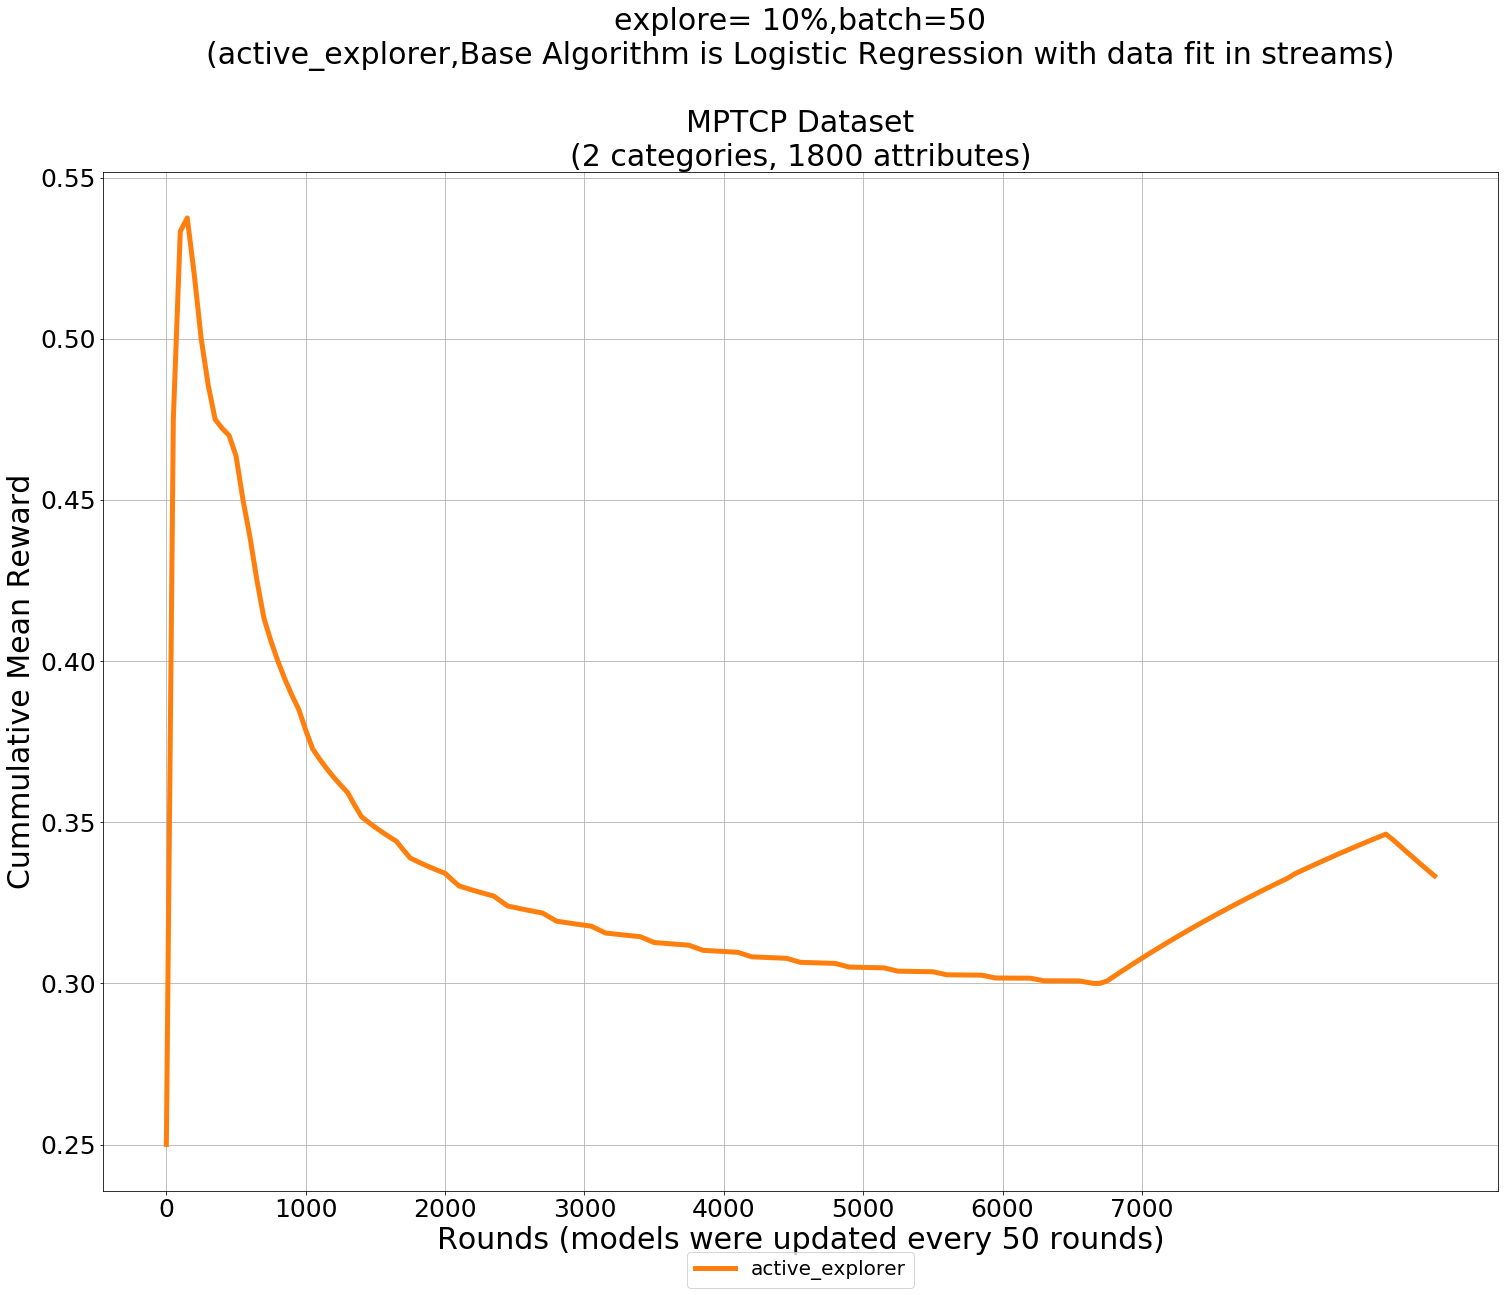

In [27]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('explore= 10%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

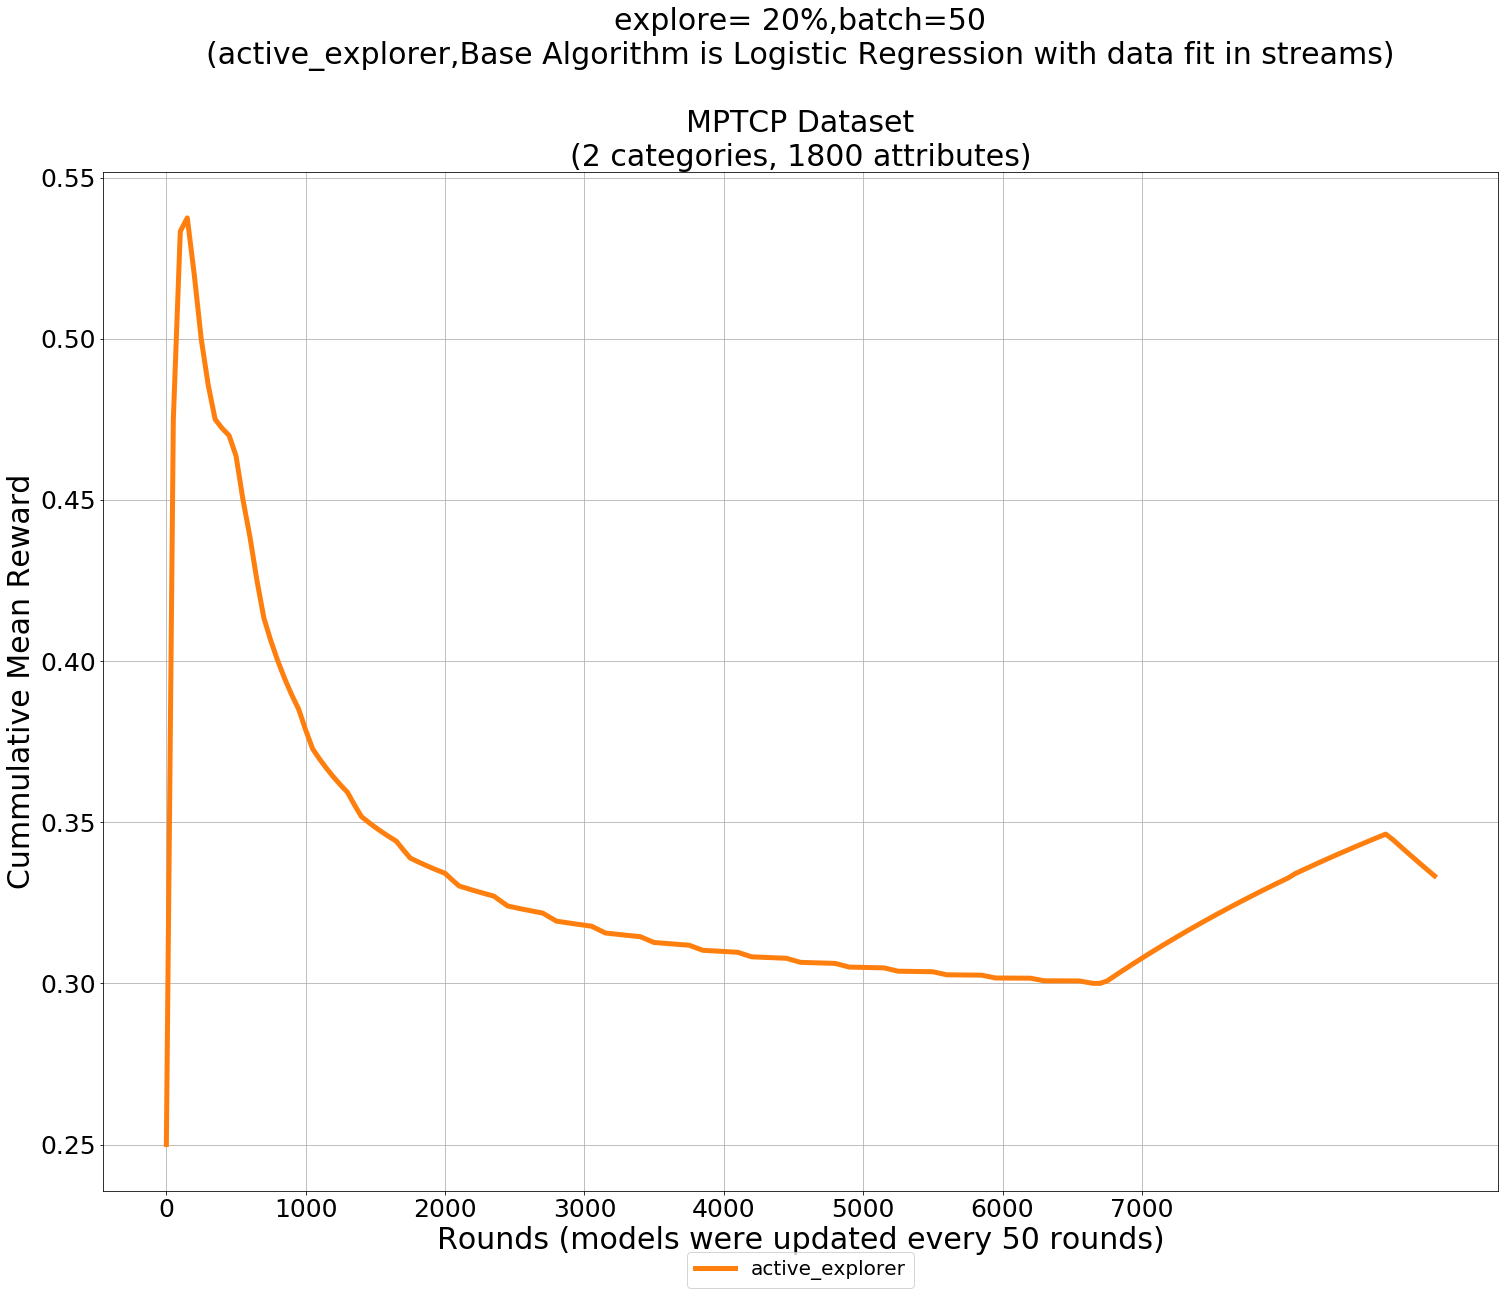

In [30]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('explore= 20%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

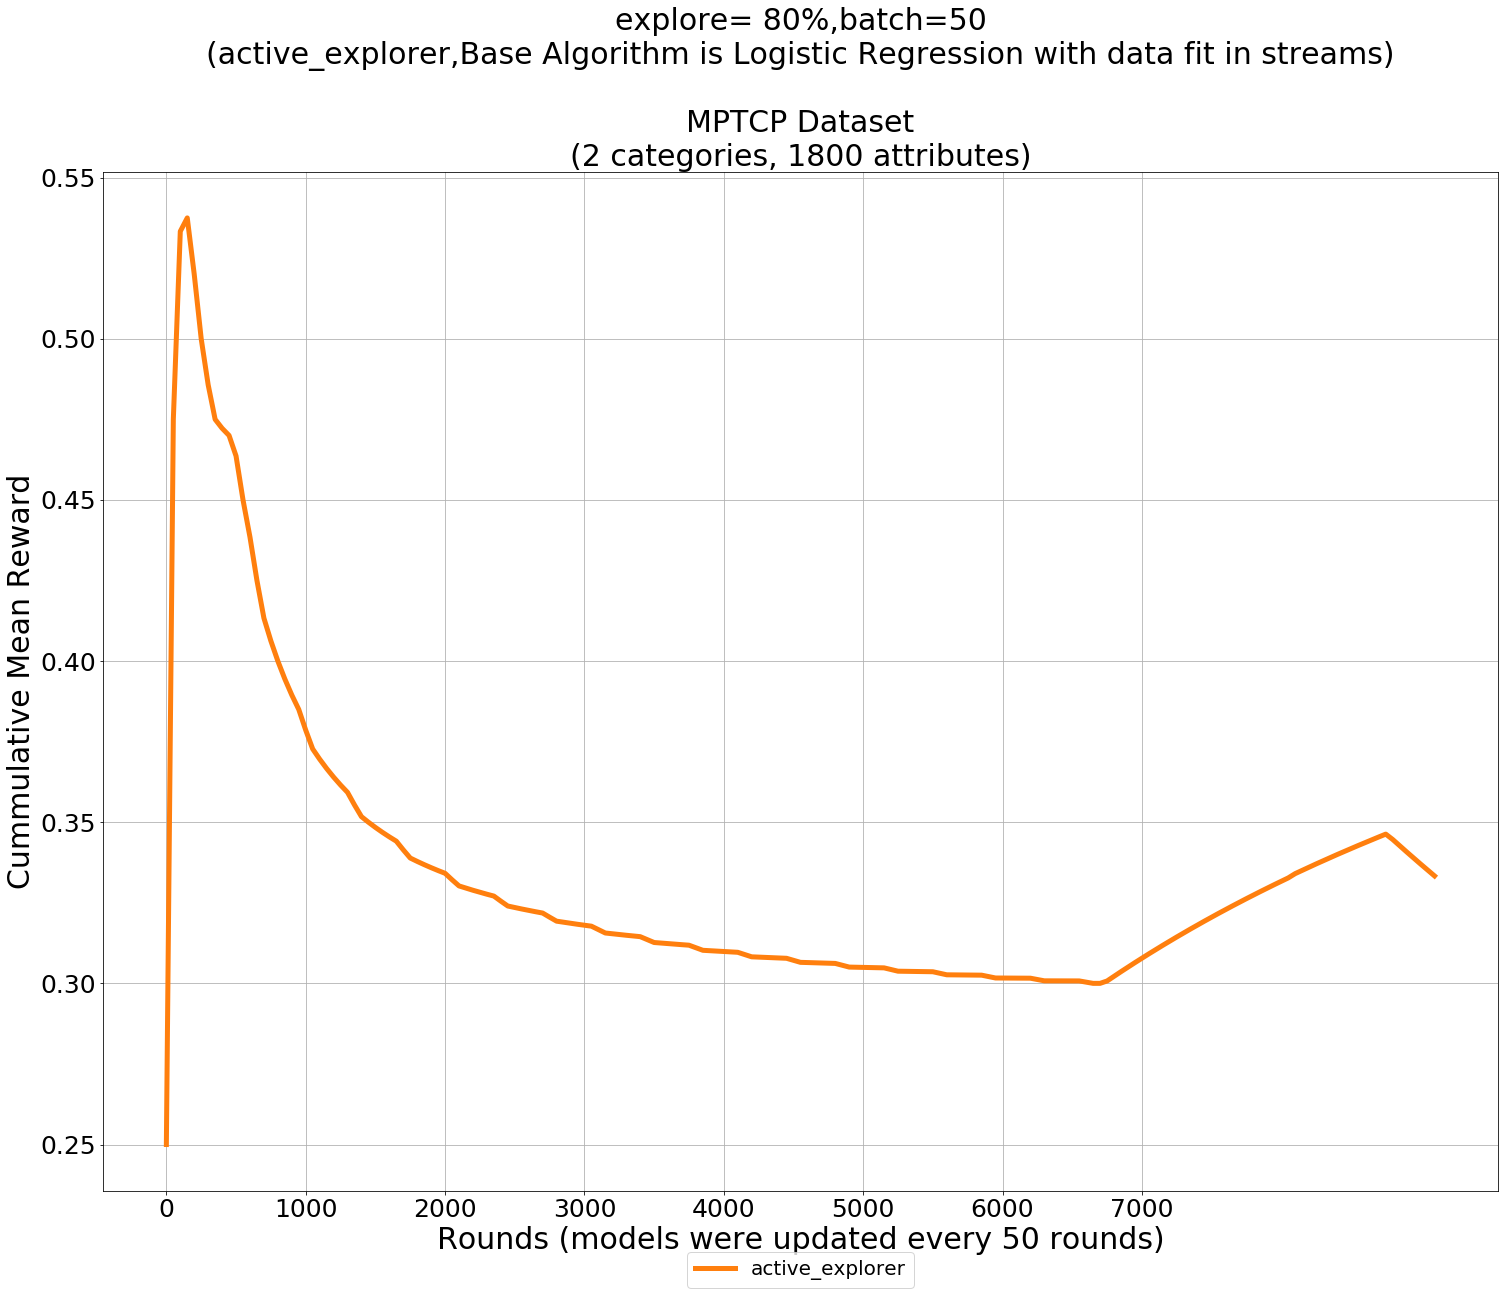

In [33]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('explore= 80%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

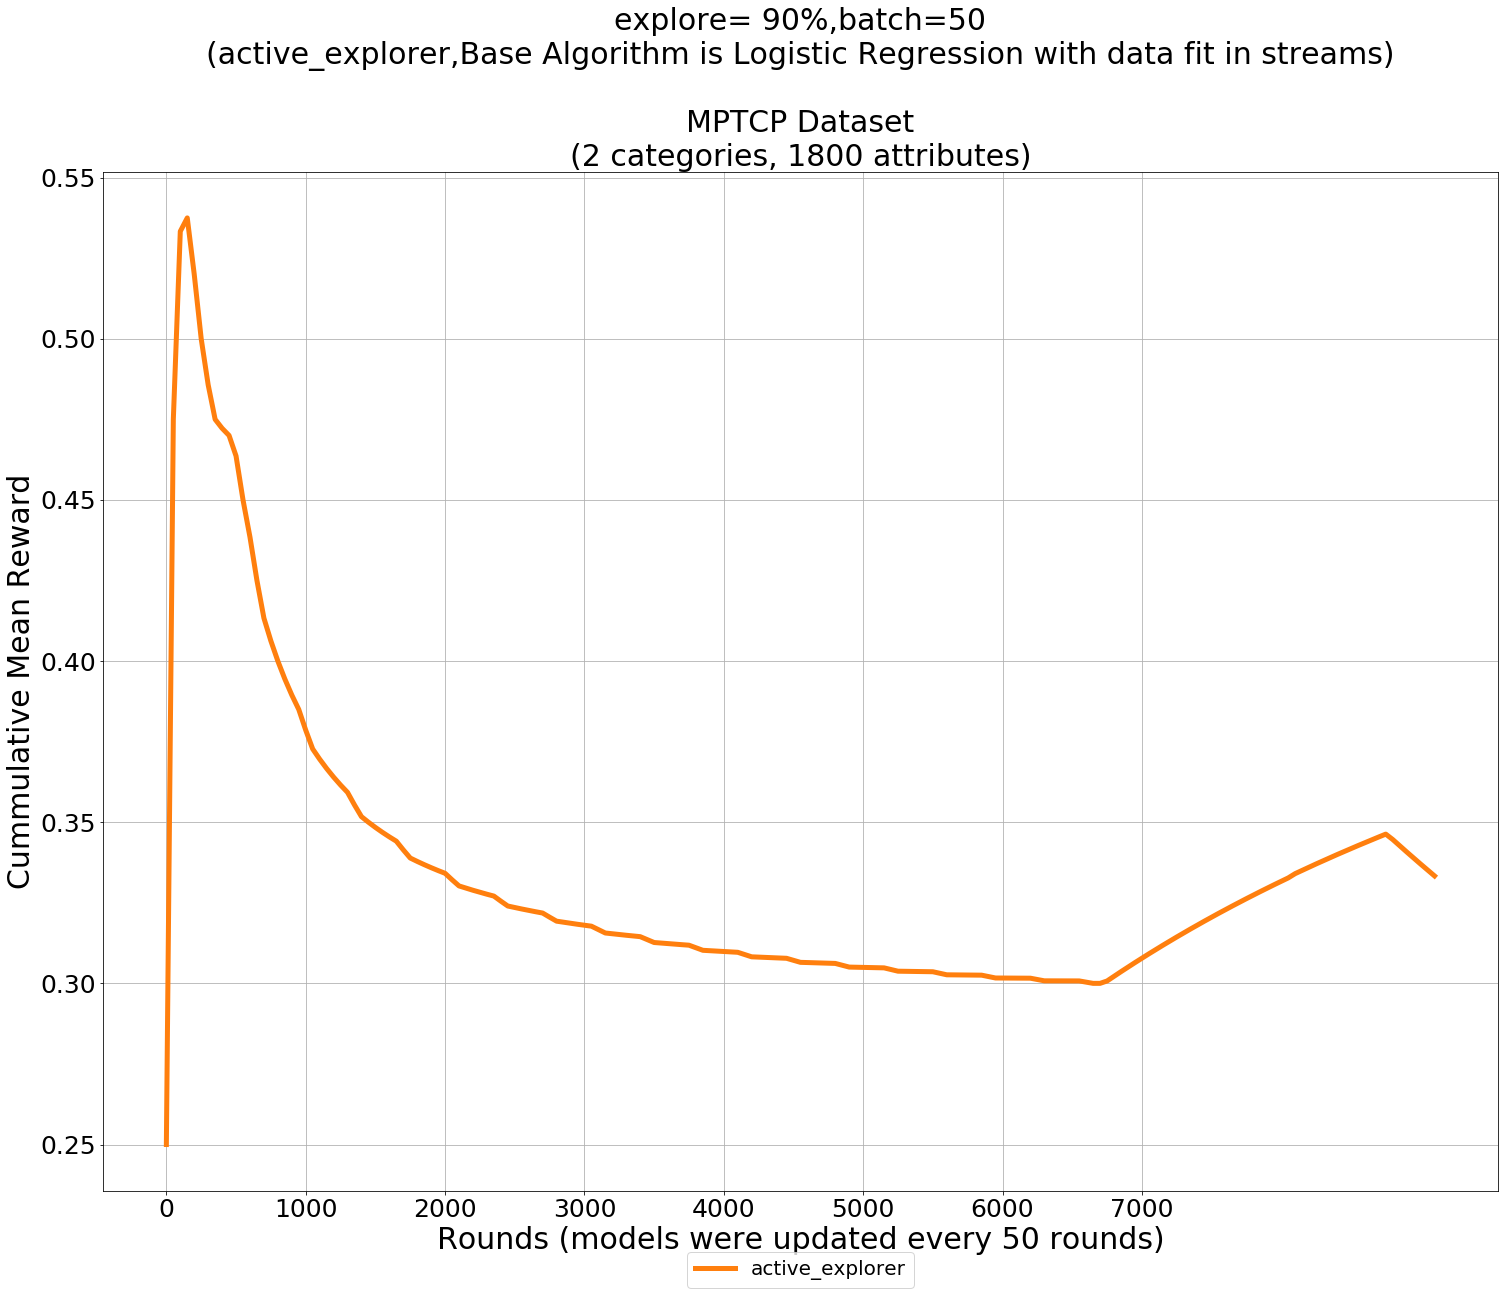

In [36]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('explore= 90%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

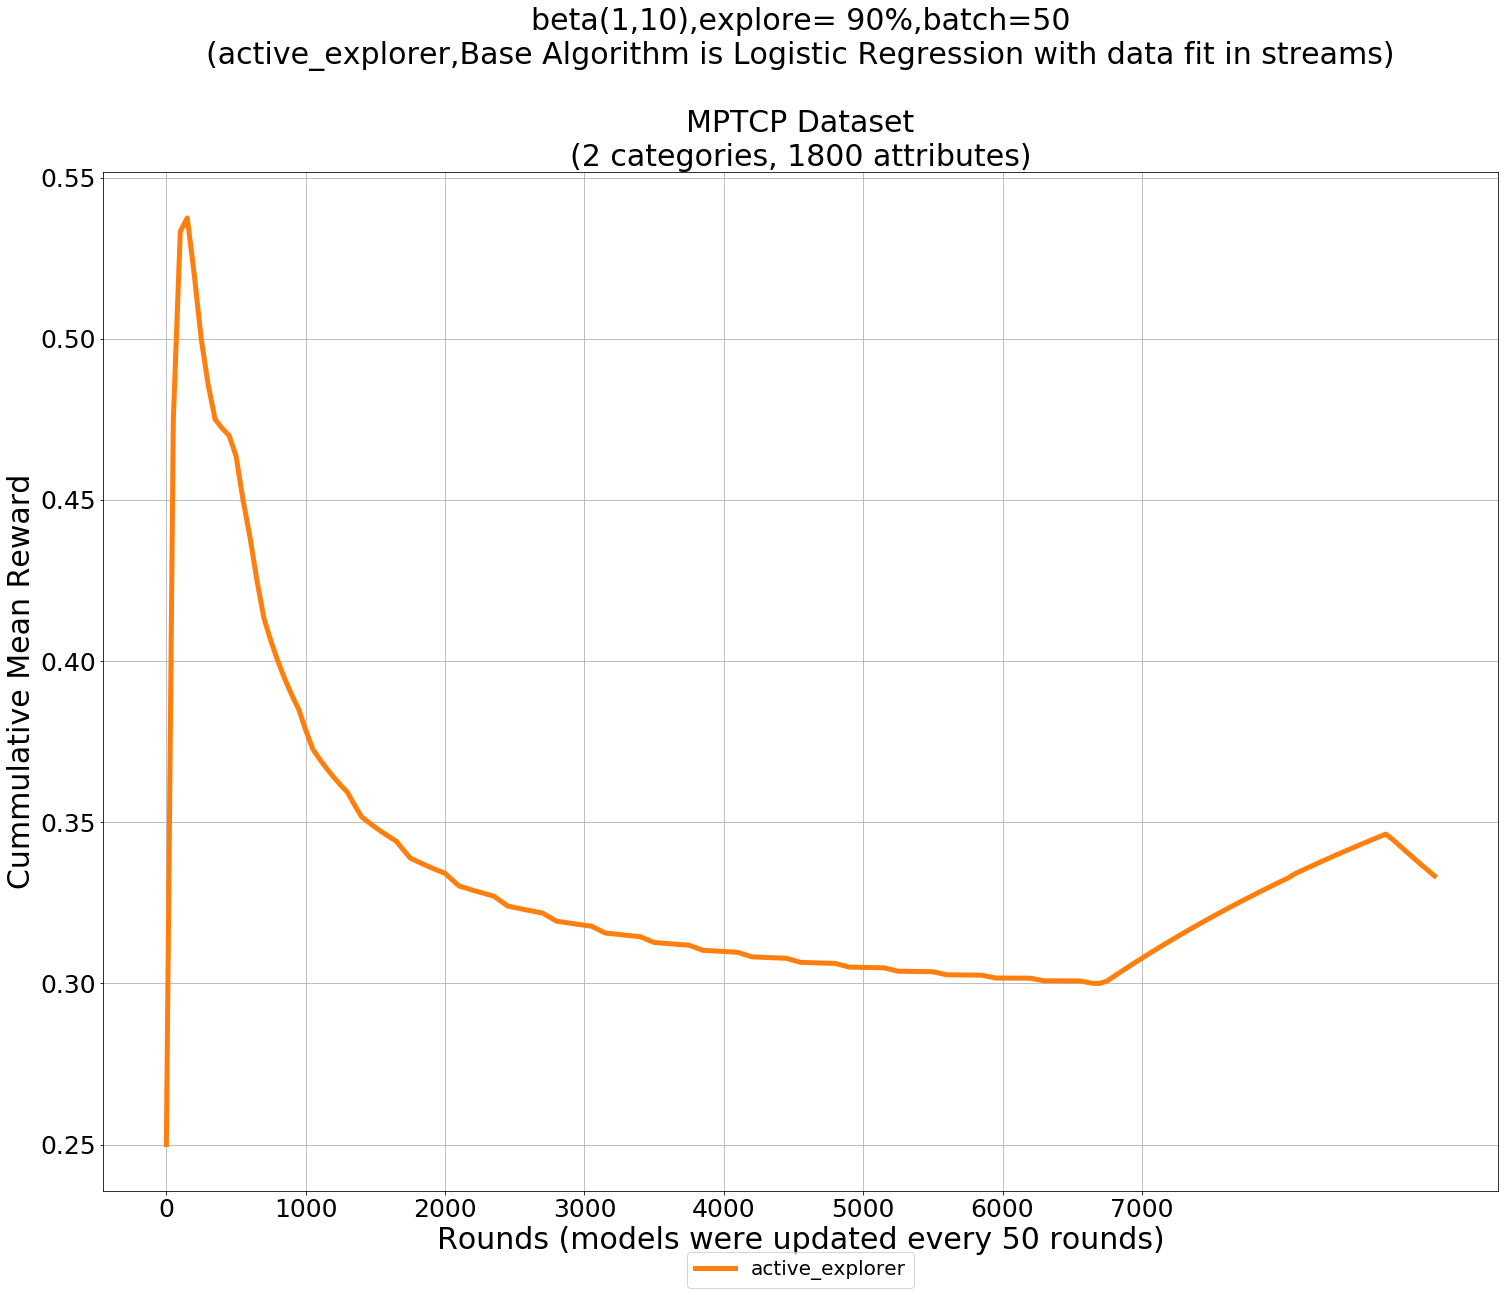

In [39]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('beta(1,10),explore= 90%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

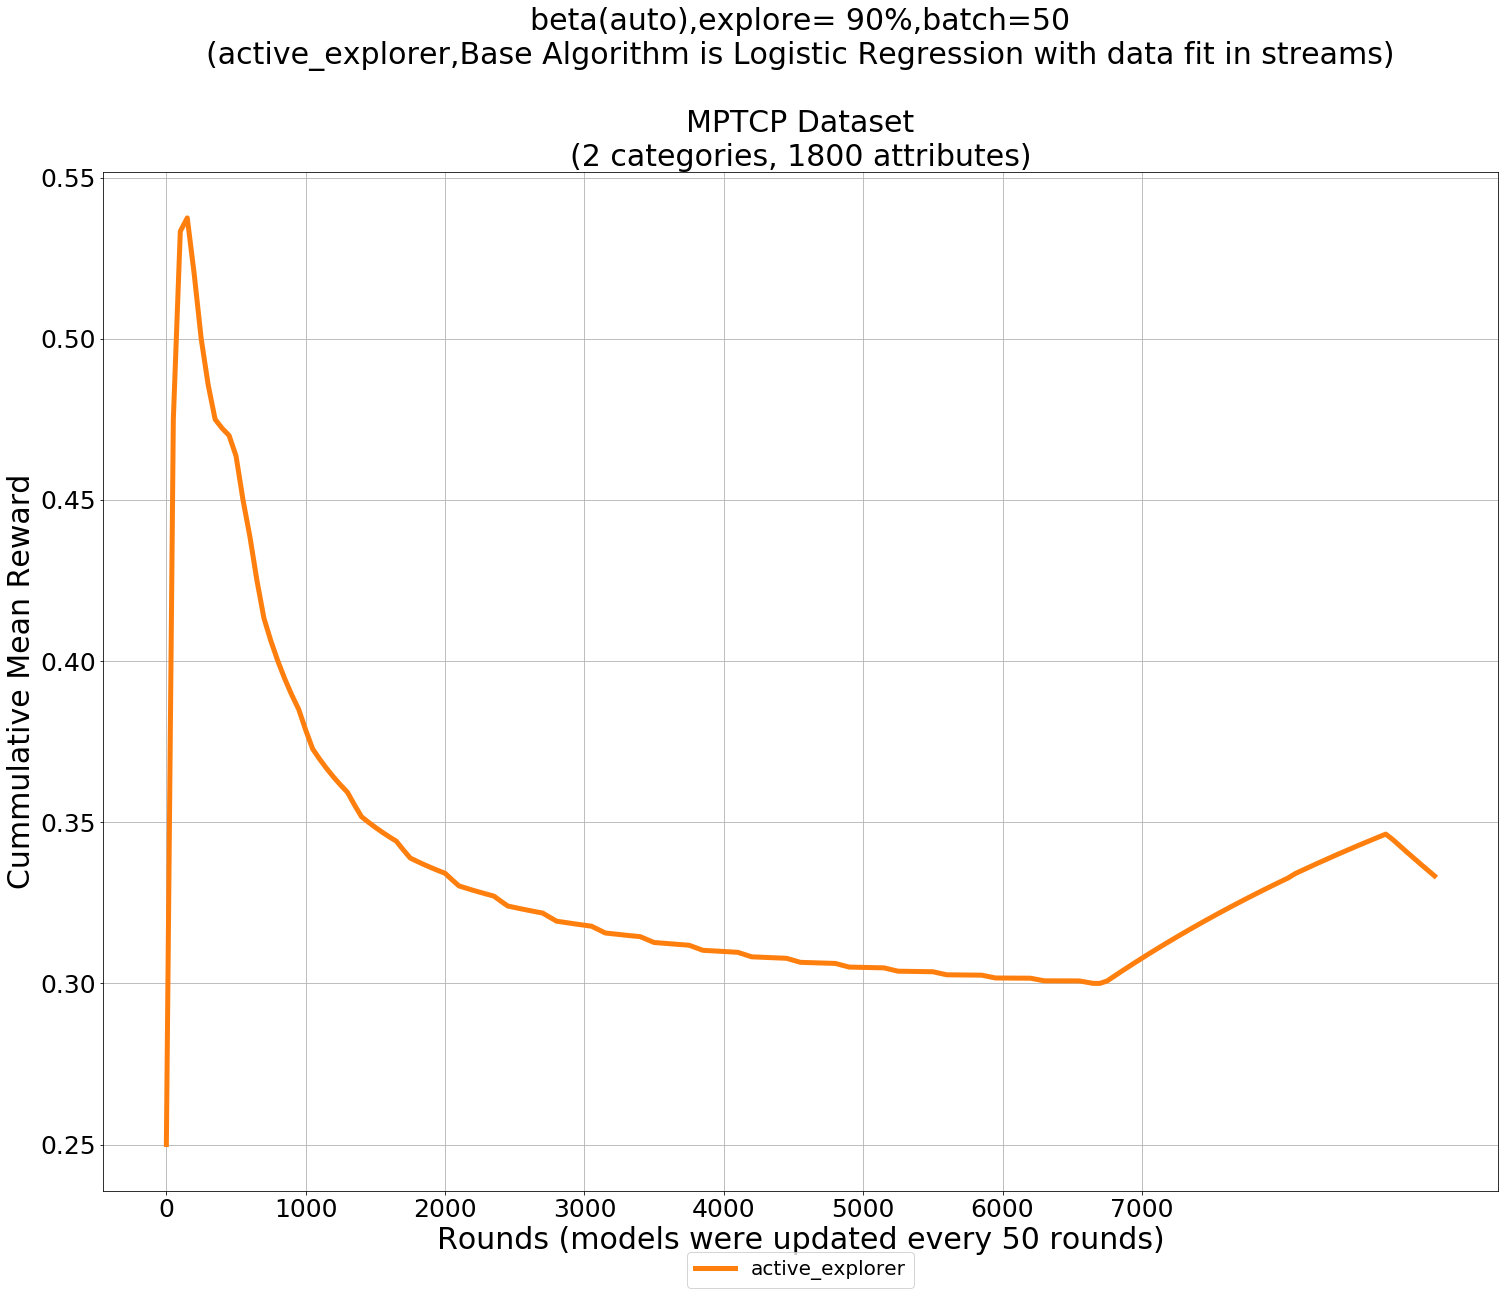

In [43]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('beta(auto),explore= 90%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

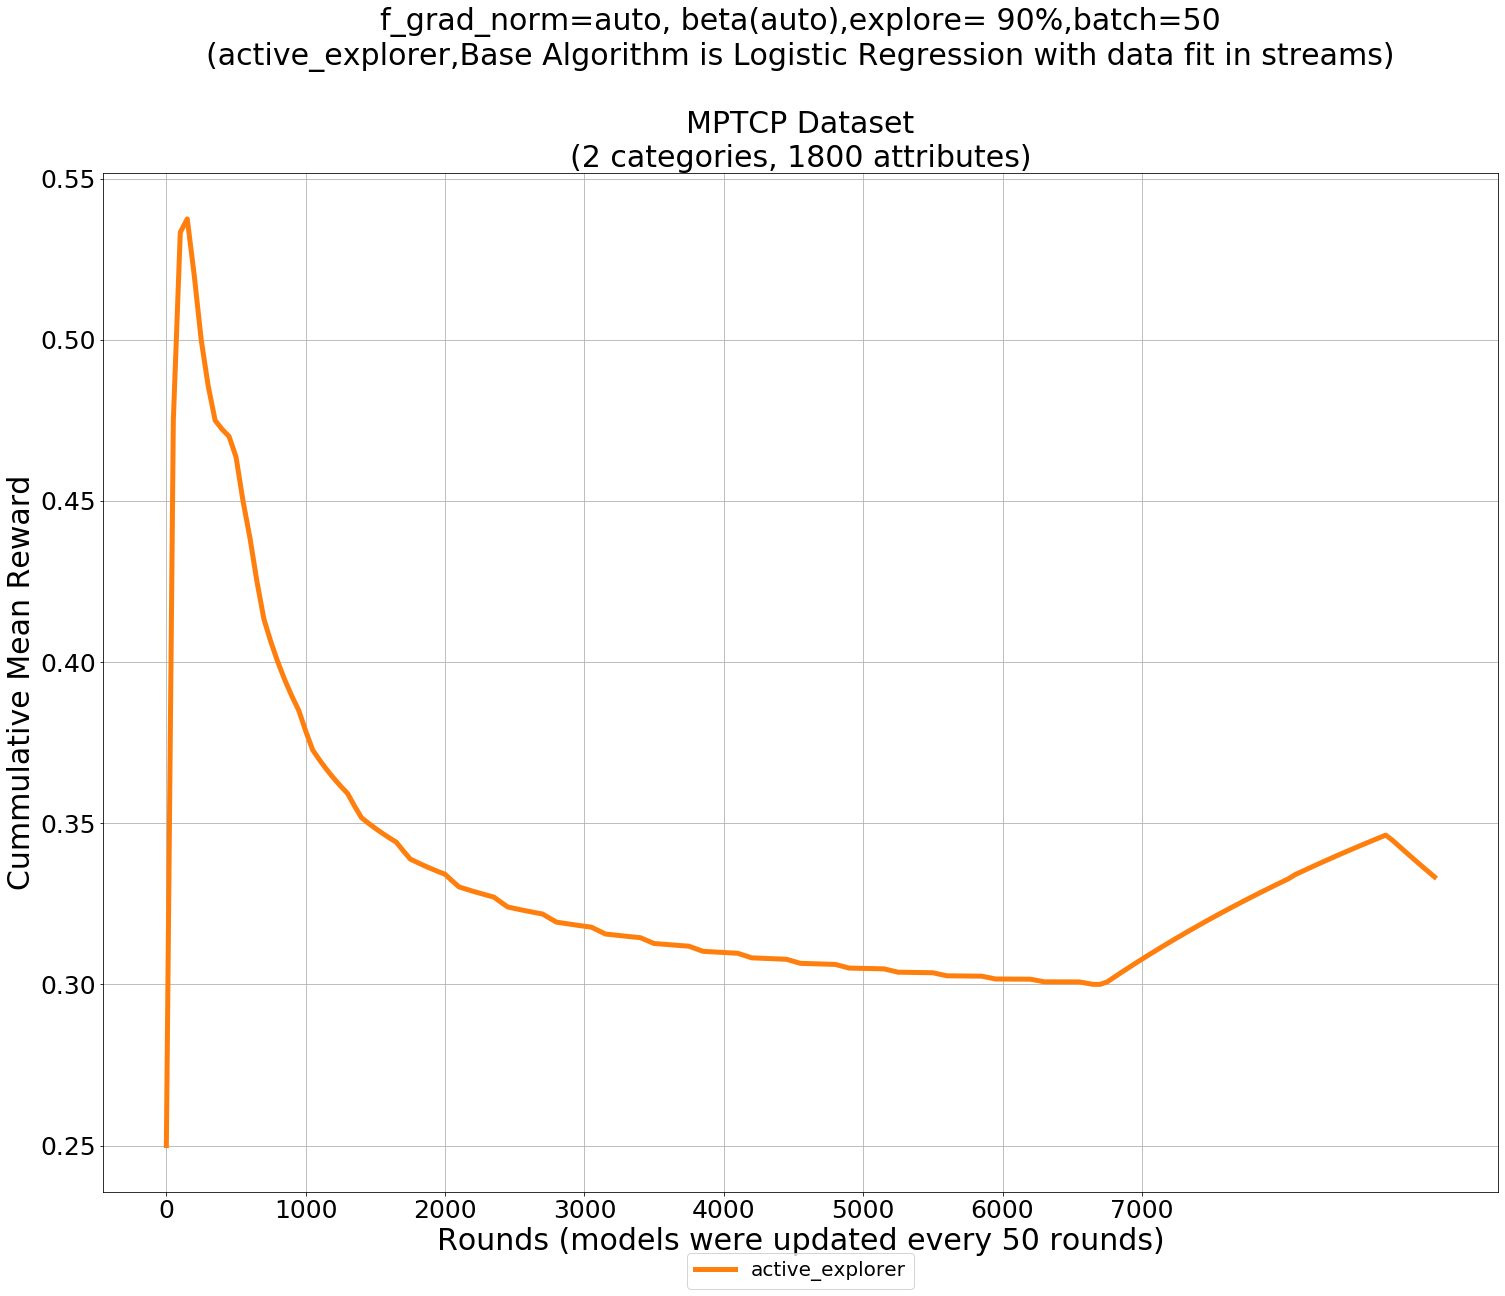

In [46]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('f_grad_norm=auto, beta(auto),explore= 90%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

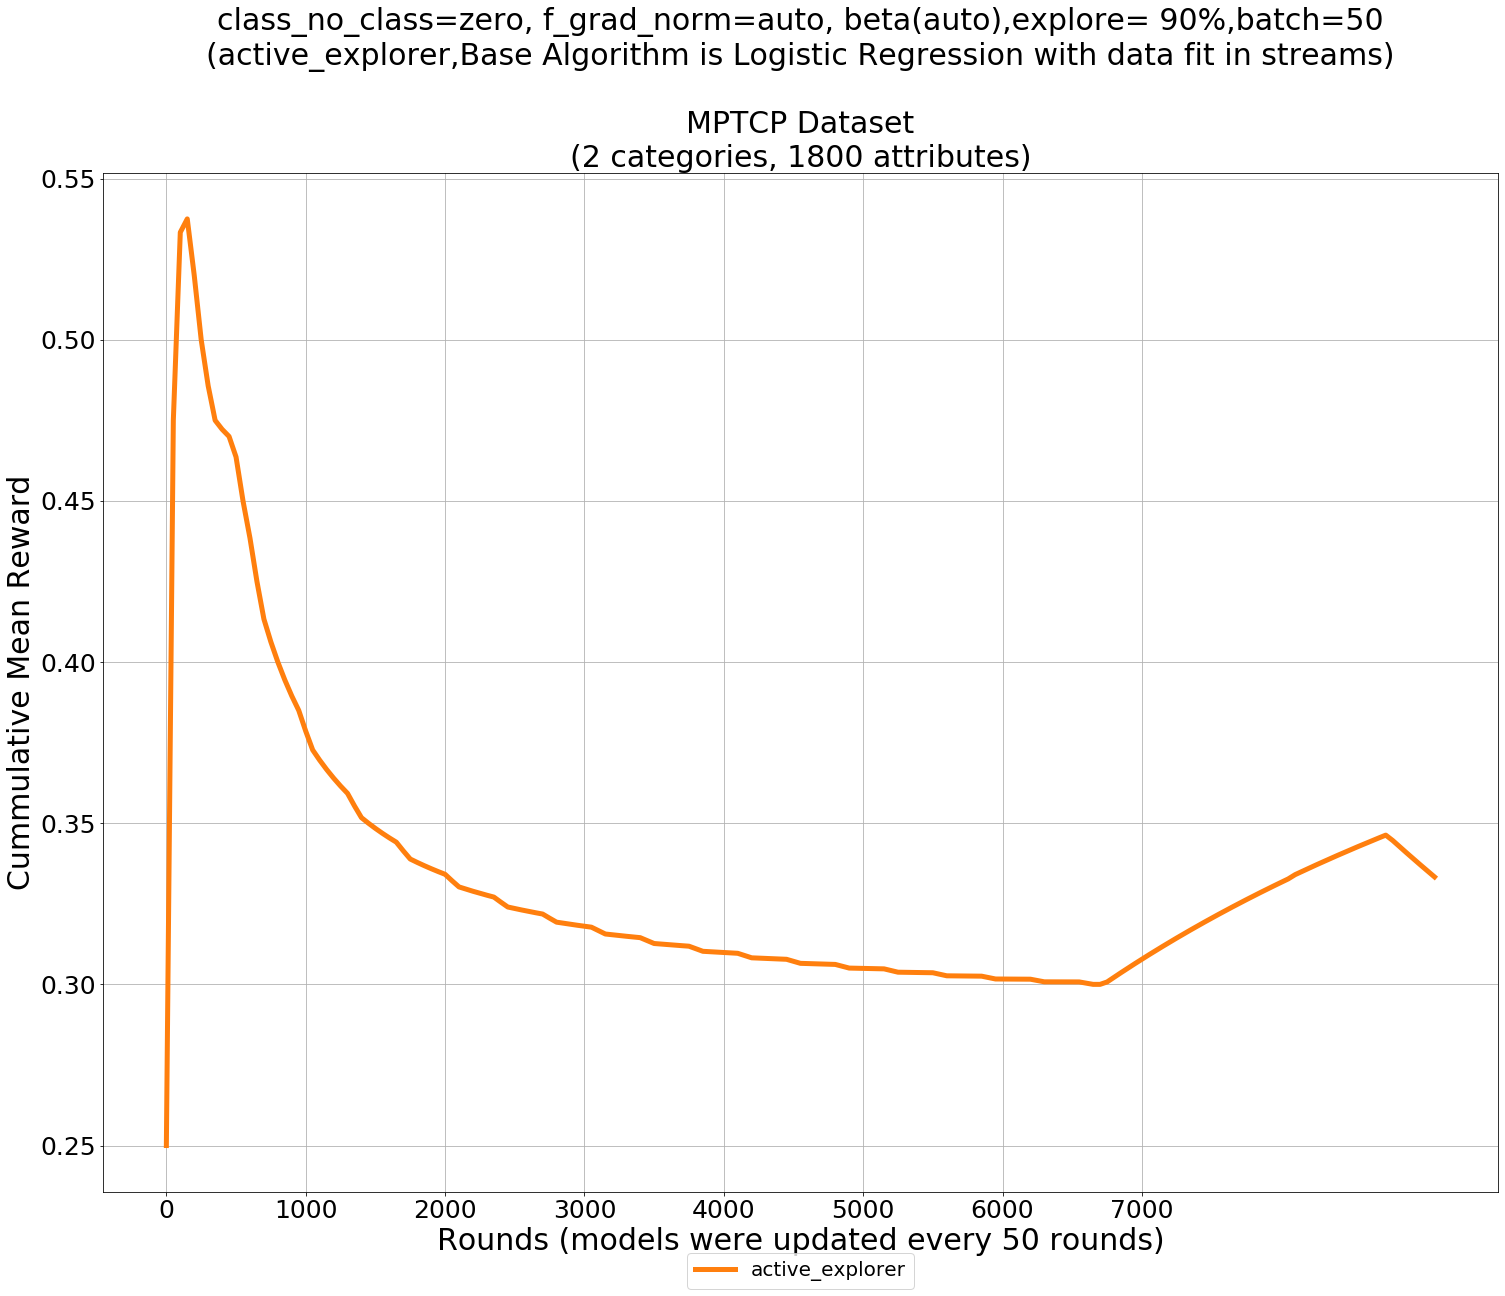

In [49]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('class_no_class=zero, f_grad_norm=auto, beta(auto),explore= 90%,batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

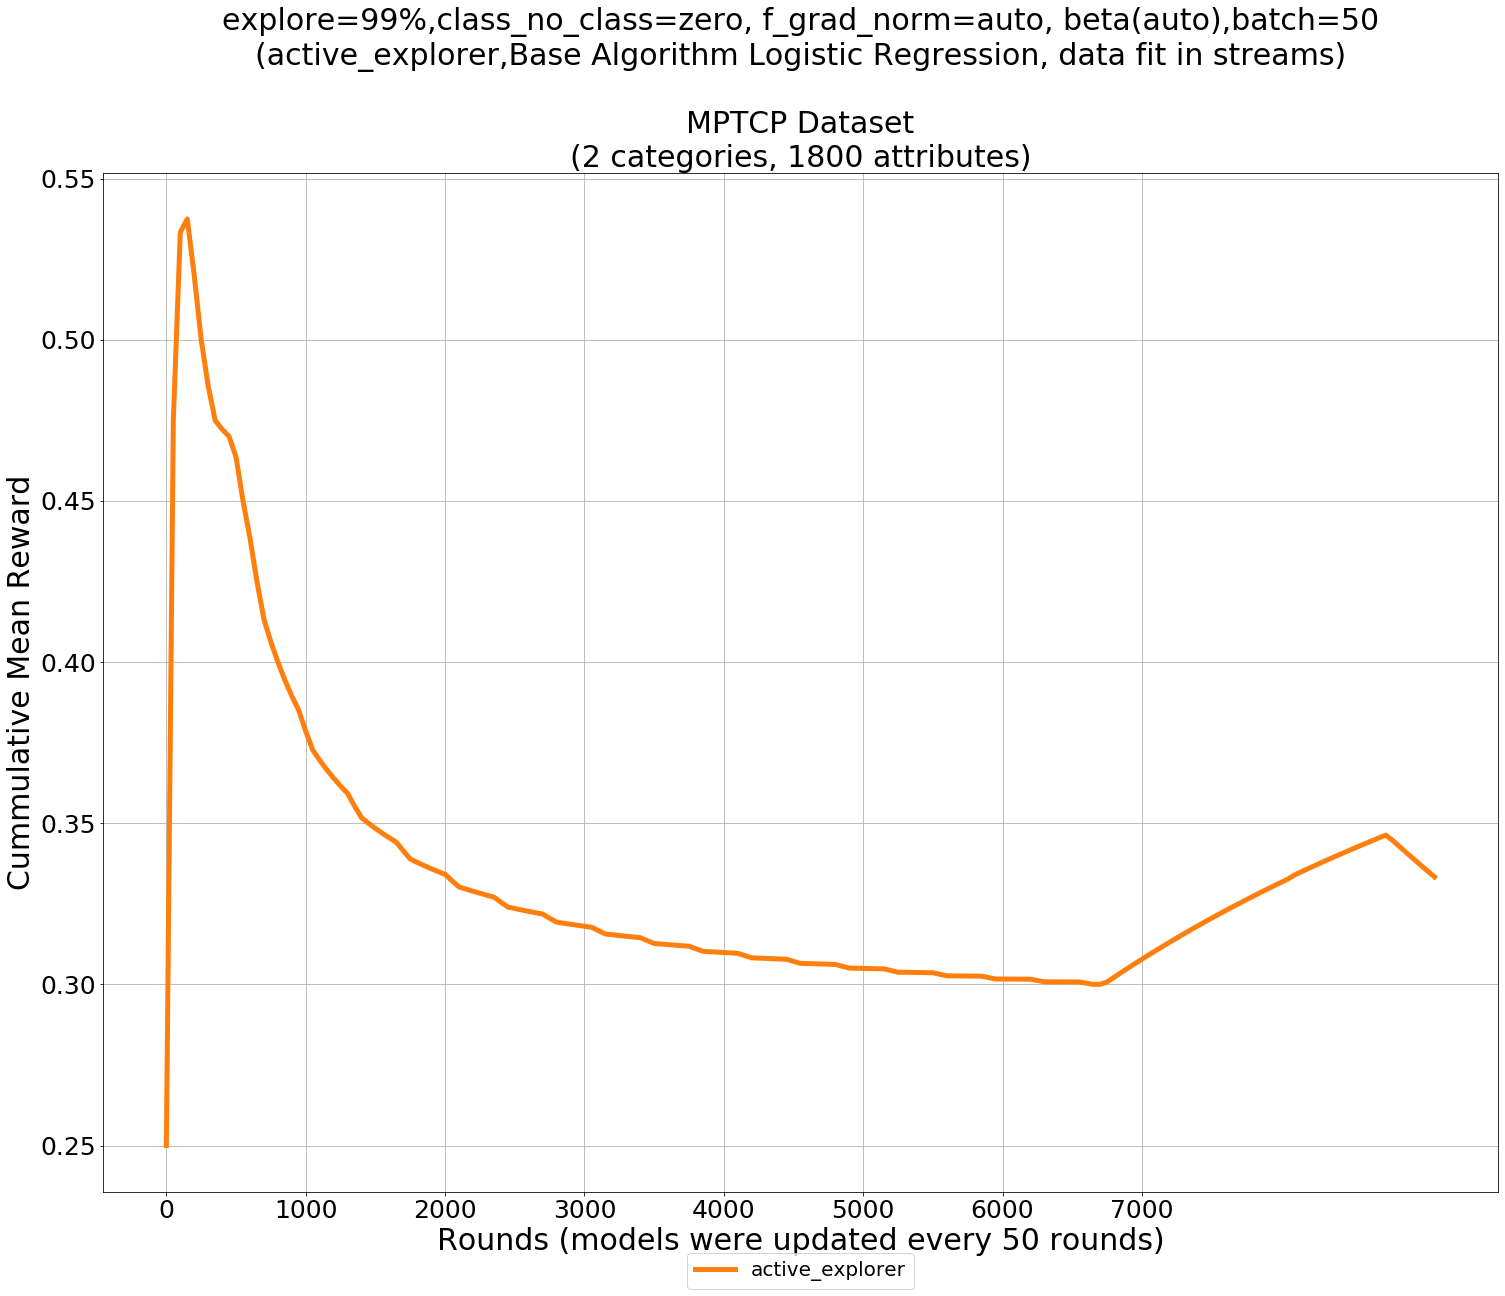

In [52]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('explore=99%,class_no_class=zero, f_grad_norm=auto, beta(auto),batch=50\n(active_explorer,Base Algorithm Logistic Regression, data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

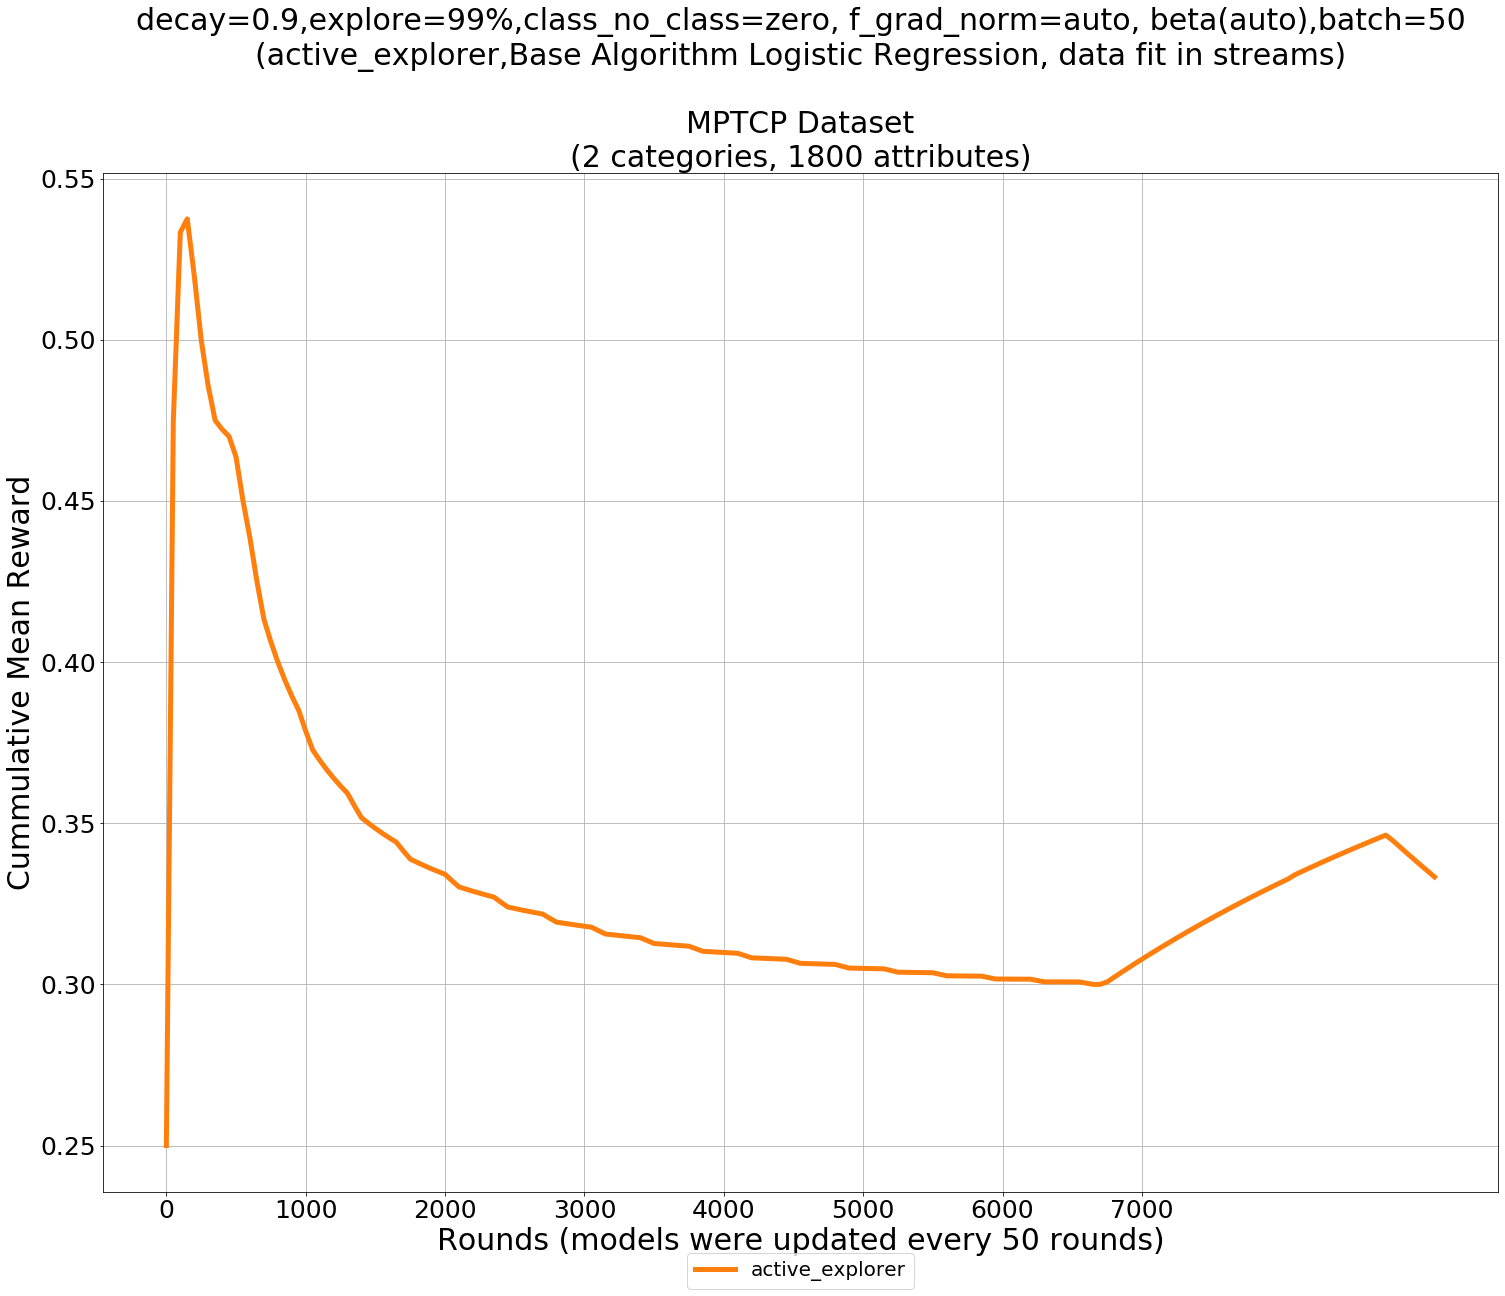

In [55]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('decay=0.9,explore=99%,class_no_class=zero, f_grad_norm=auto, beta(auto),batch=50\n(active_explorer,Base Algorithm Logistic Regression, data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

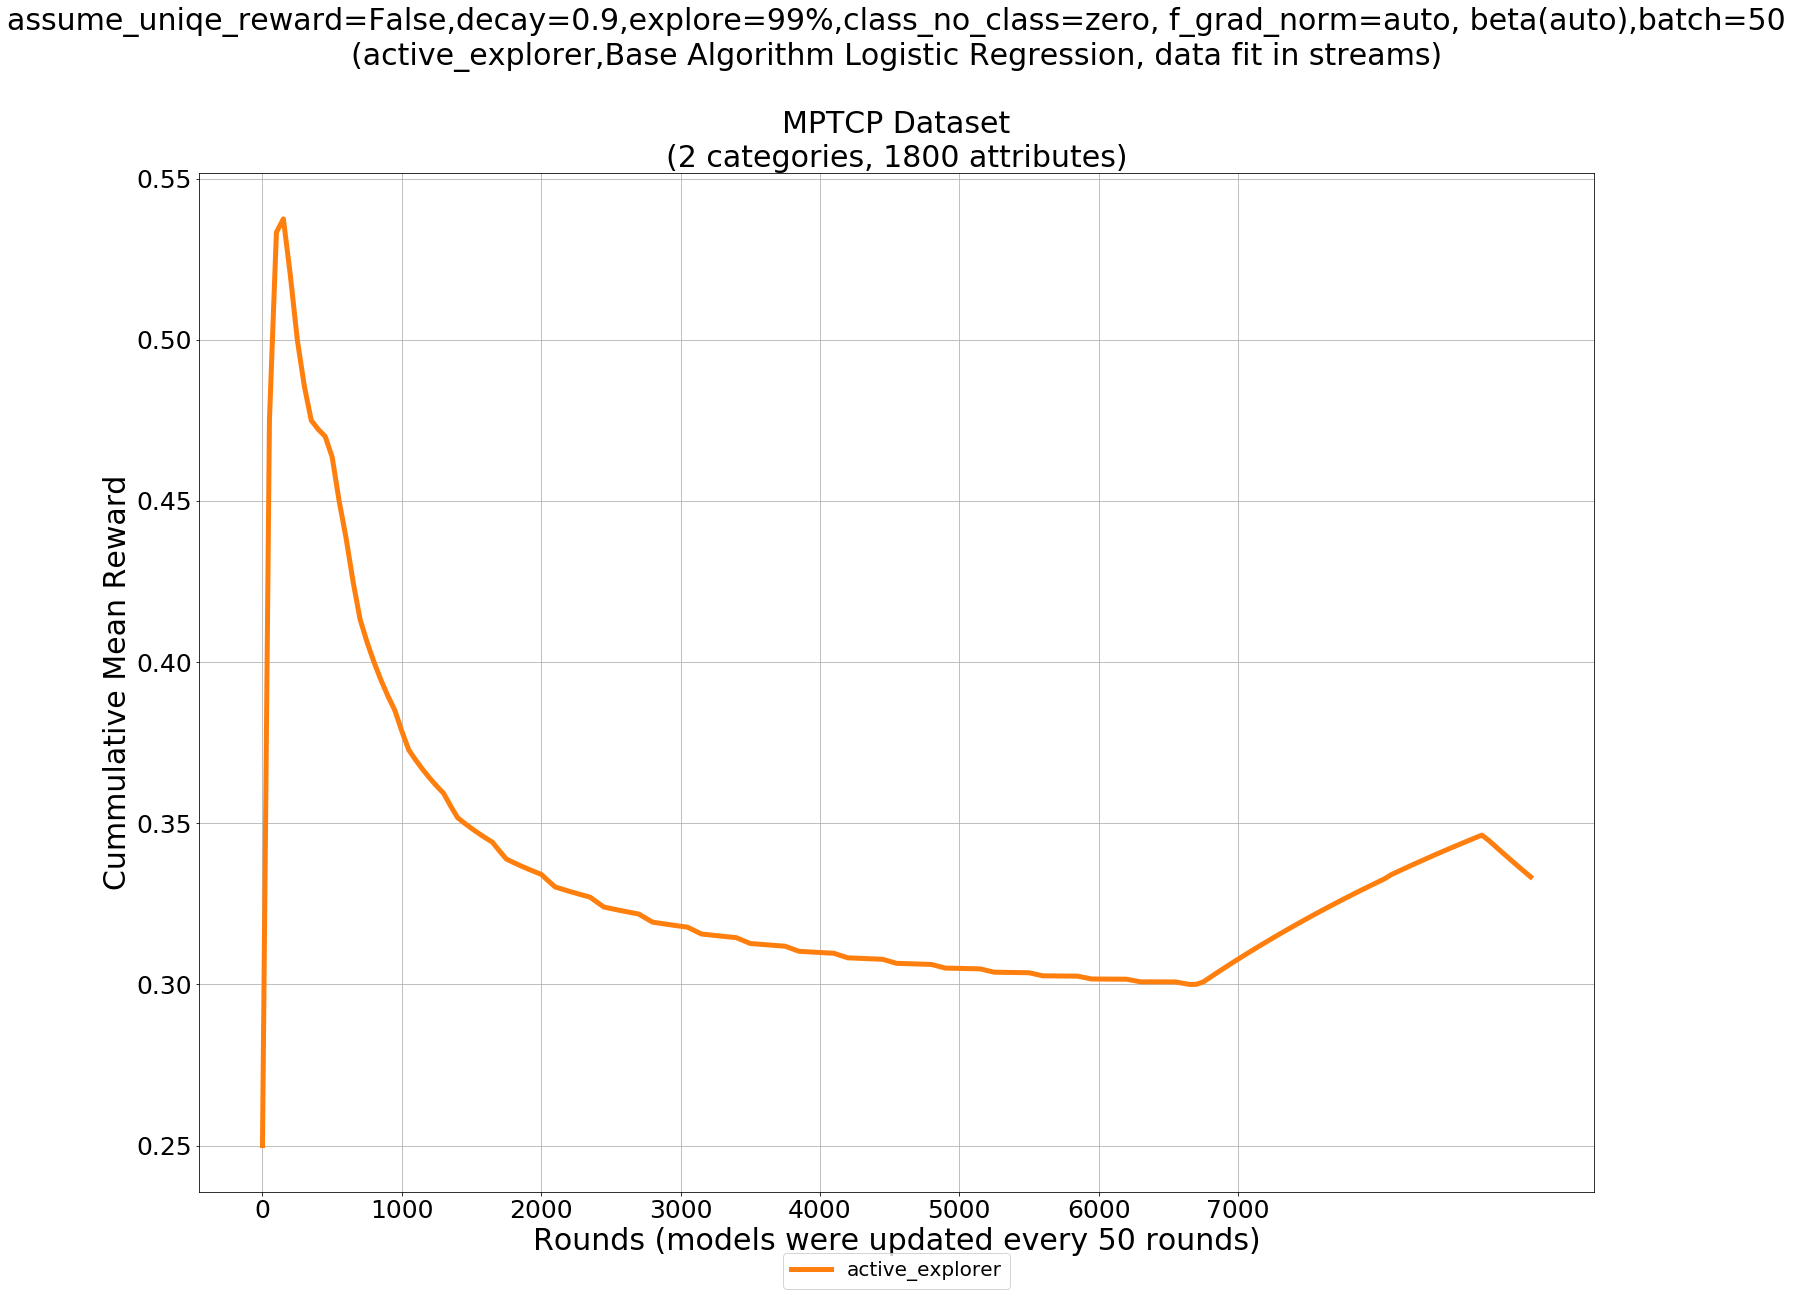

In [58]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('assume_uniqe_reward=False,decay=0.9,explore=99%,class_no_class=zero, f_grad_norm=auto, beta(auto),batch=50\n(active_explorer,Base Algorithm Logistic Regression, data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

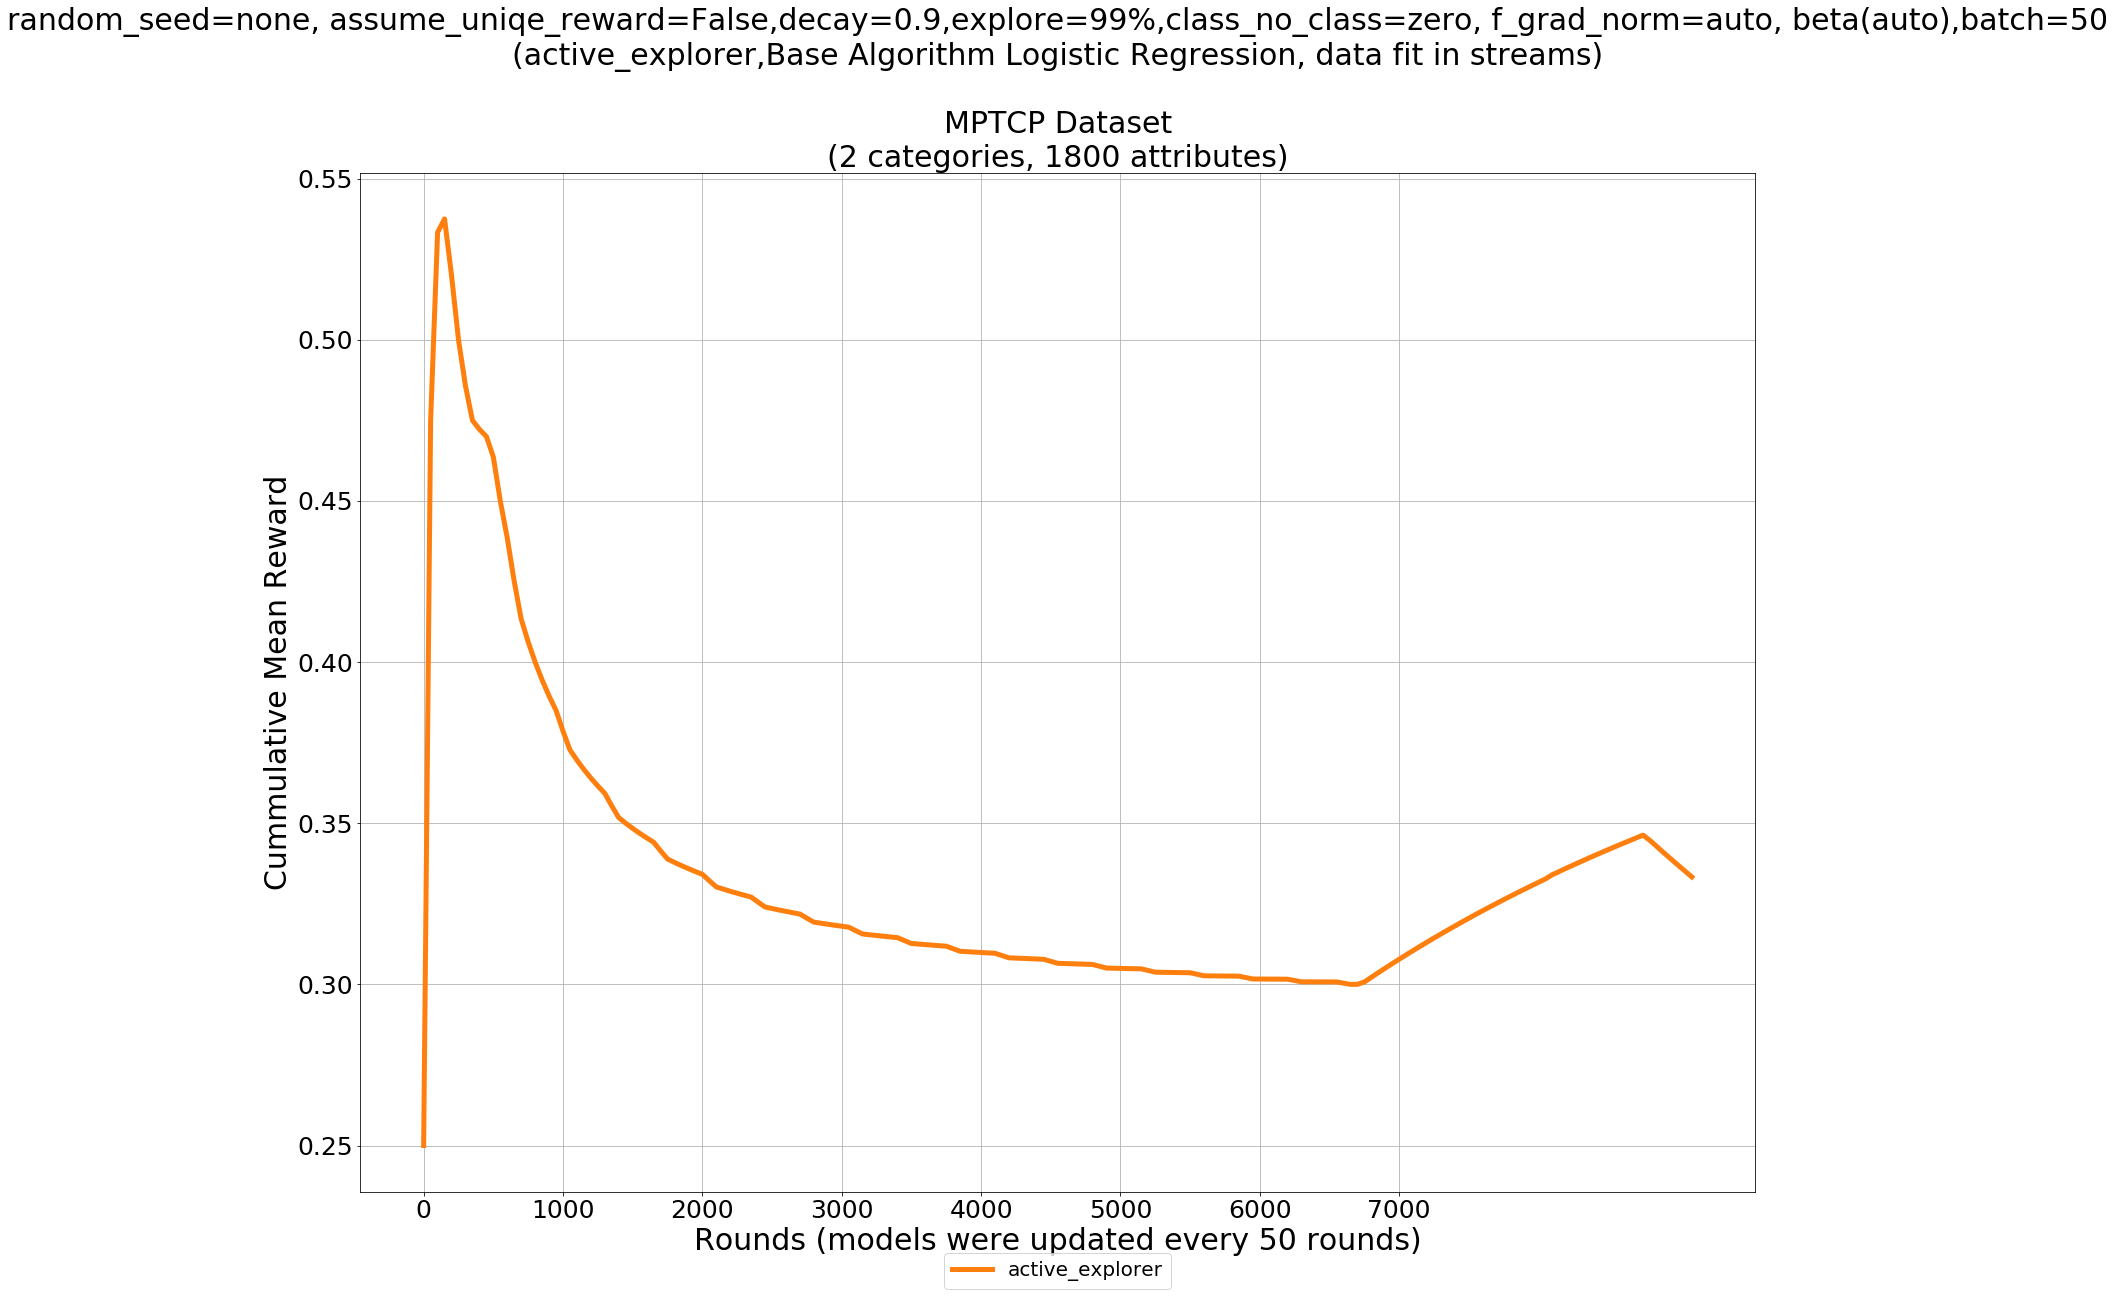

In [61]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('random_seed=none, assume_uniqe_reward=False,decay=0.9,explore=99%,class_no_class=zero, f_grad_norm=auto, beta(auto),batch=50\n(active_explorer,Base Algorithm Logistic Regression, data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

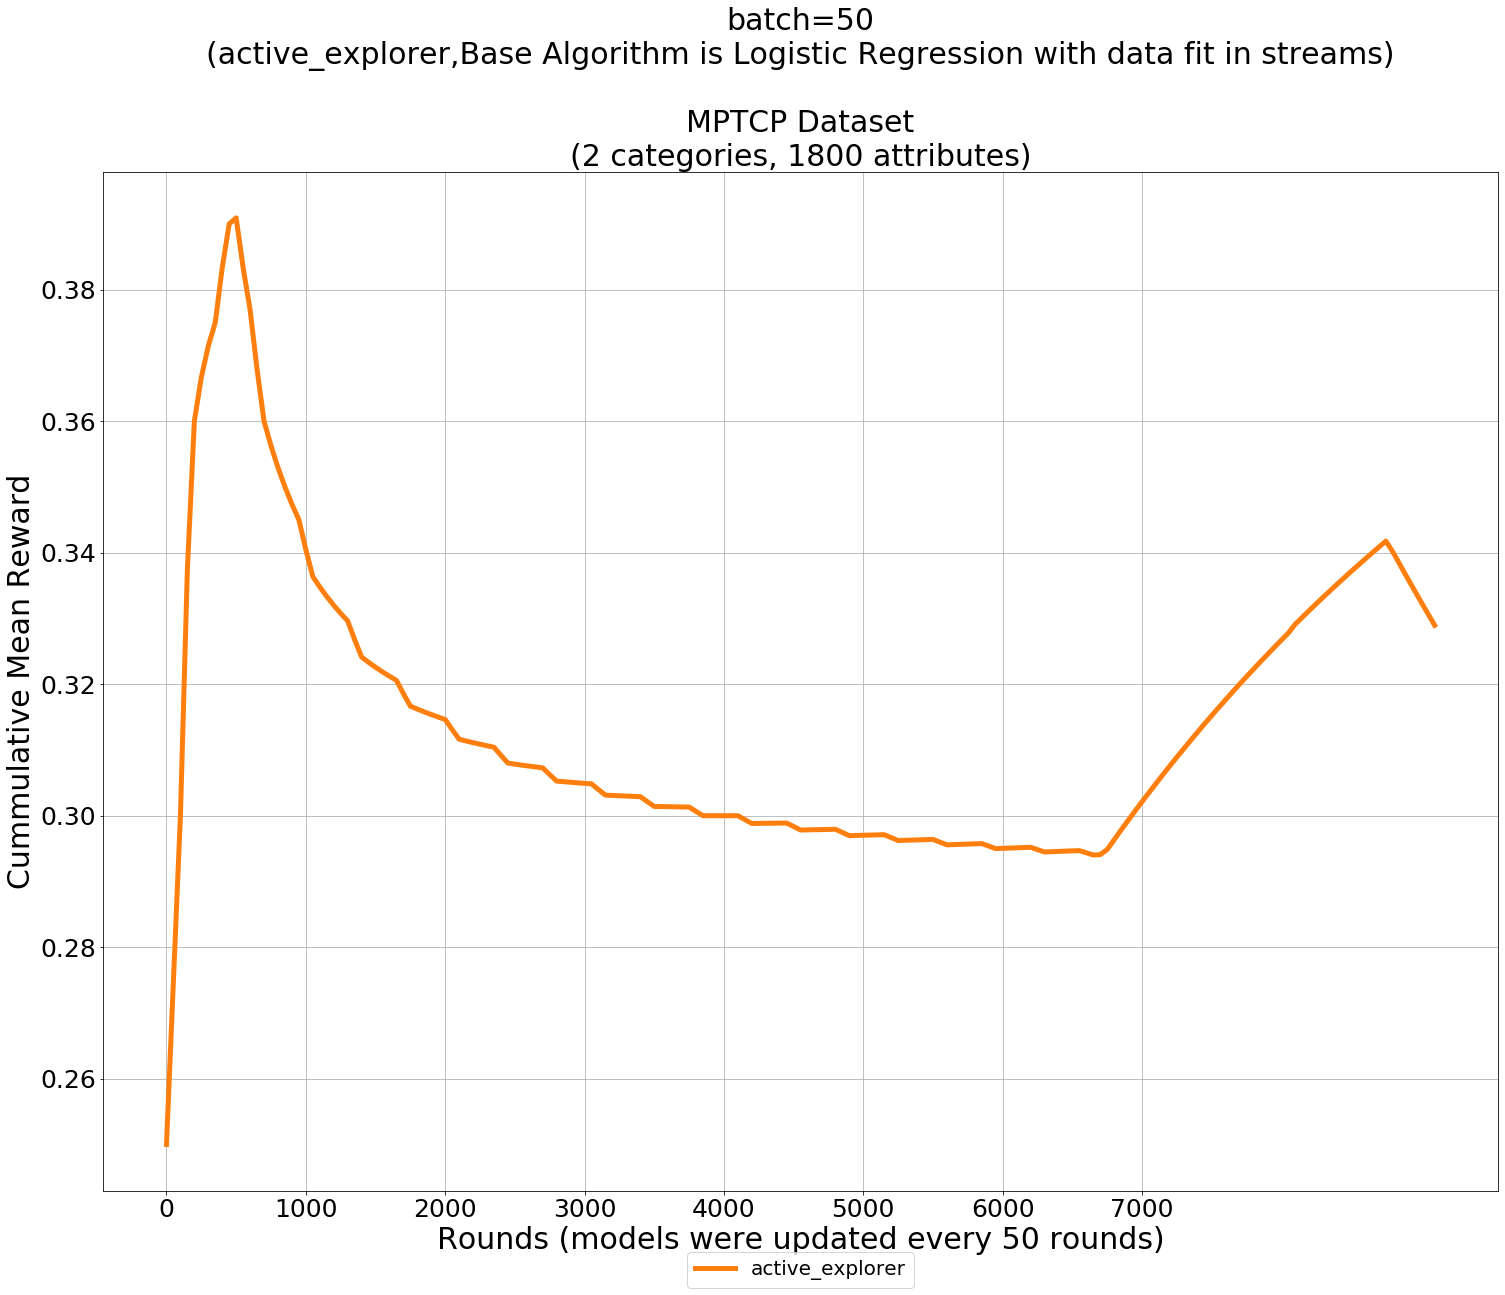

In [24]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

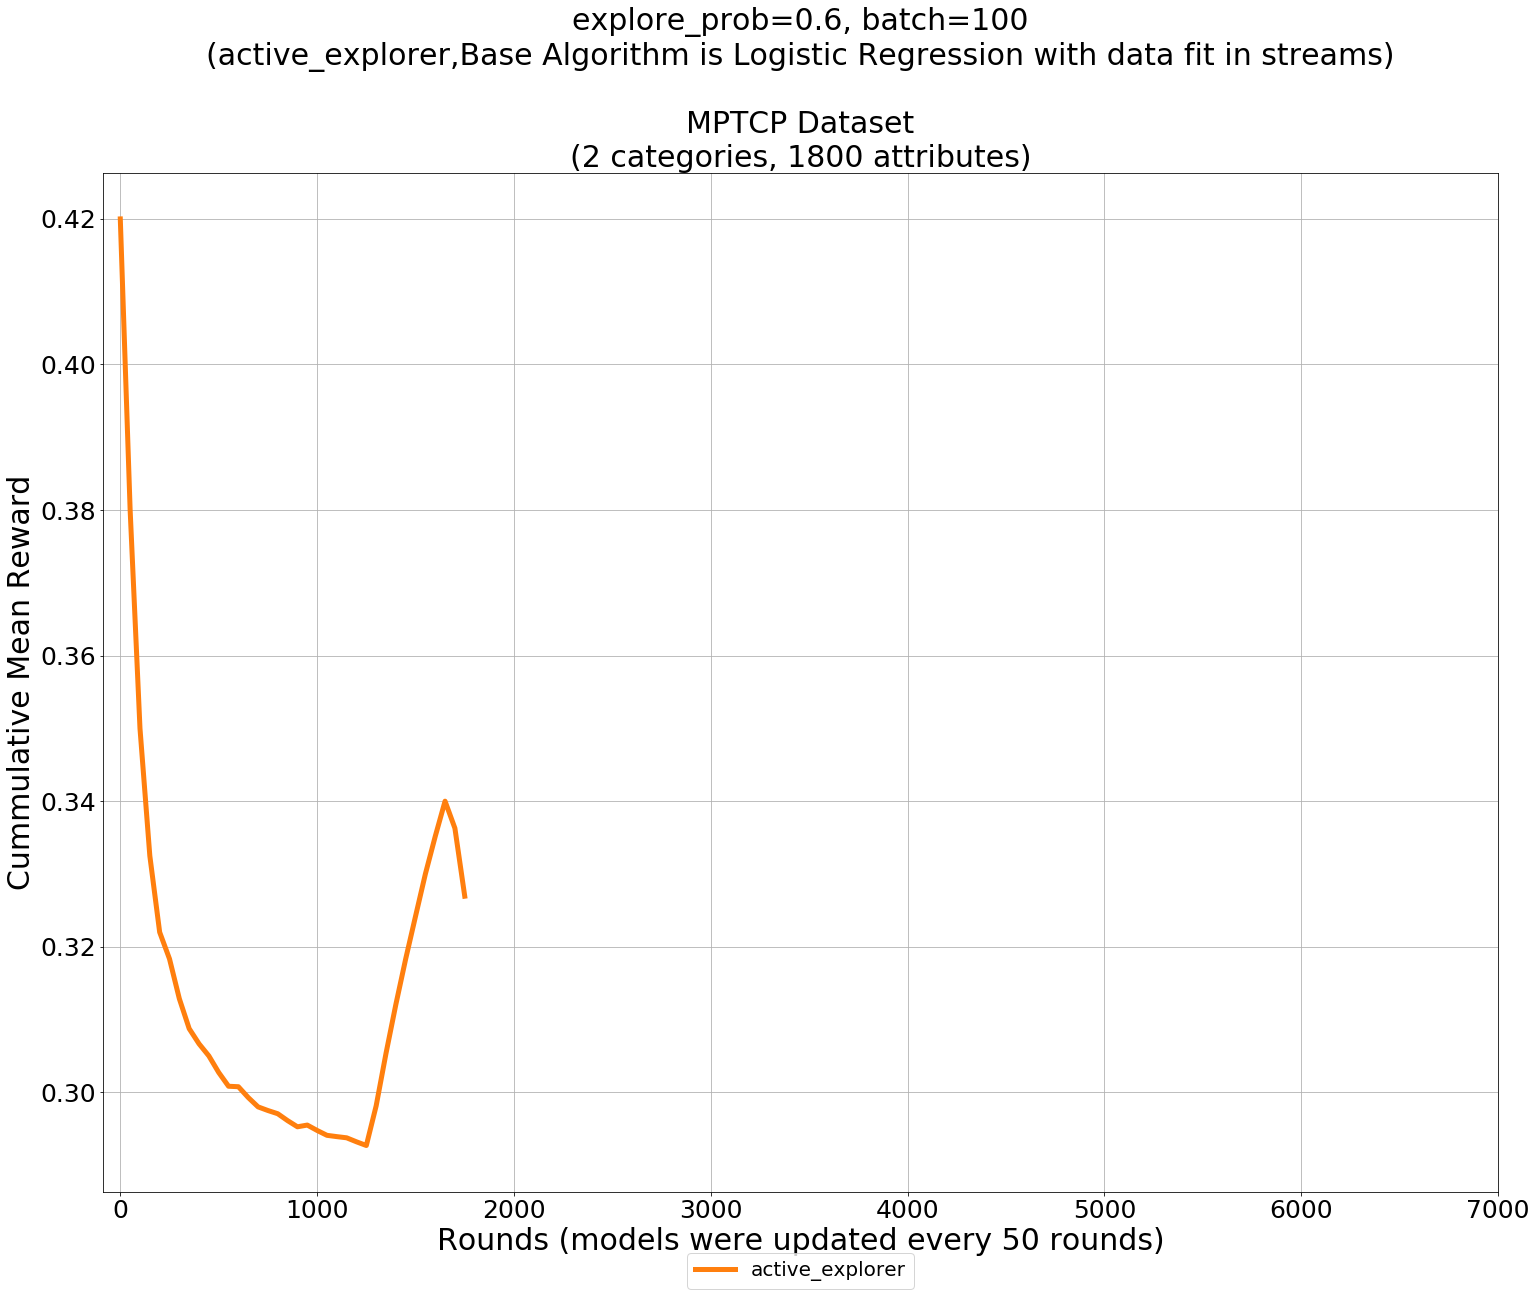

In [7]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('explore_prob=0.6, batch=100\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

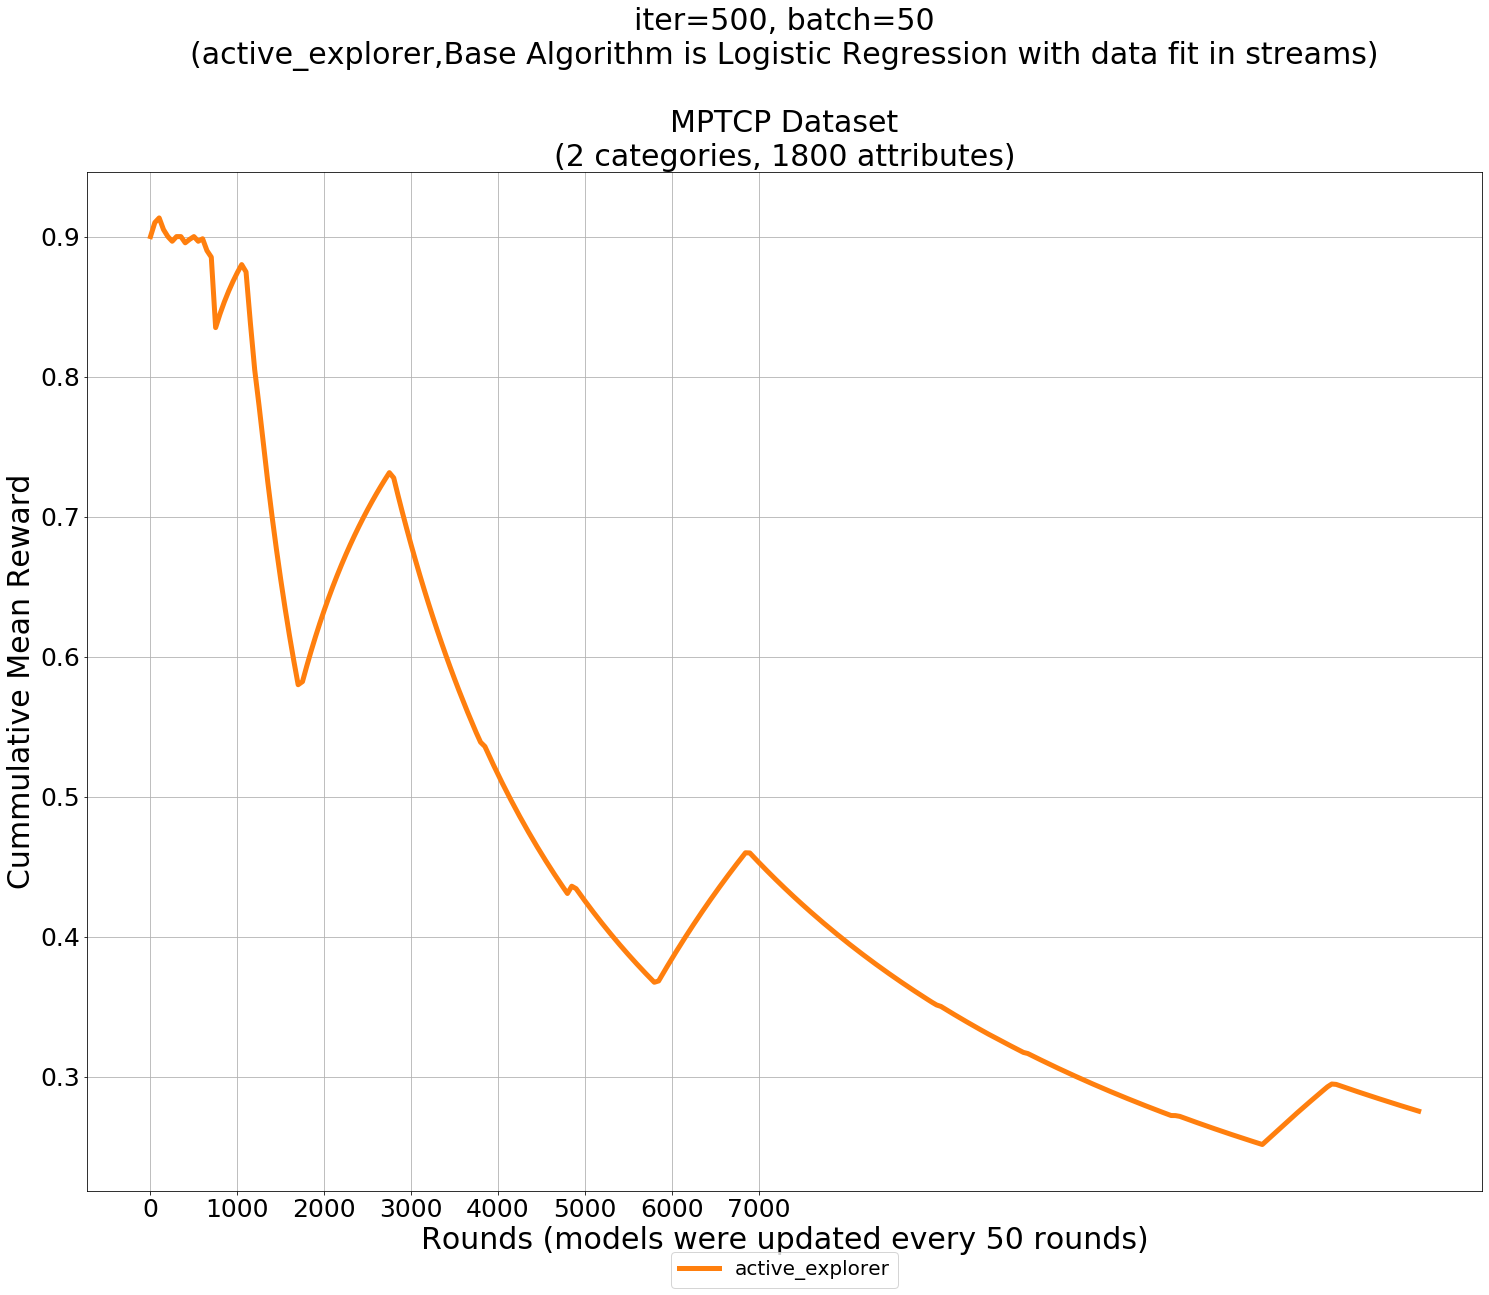

In [6]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=500, batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [19]:
#idx = np.random.randint(len(X))
#idx = list(range(0,5))
#idx = range(0,5)
# action = models[0].predict(X[13580, :]).astype("uint8")
# print(action)
for i in range(10):
    action = models[0].predict(X[i]).astype("uint8")
    print(action)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [15]:
action = models[0].predict(X[13323, :]).astype("uint8")
print(action)

[0]


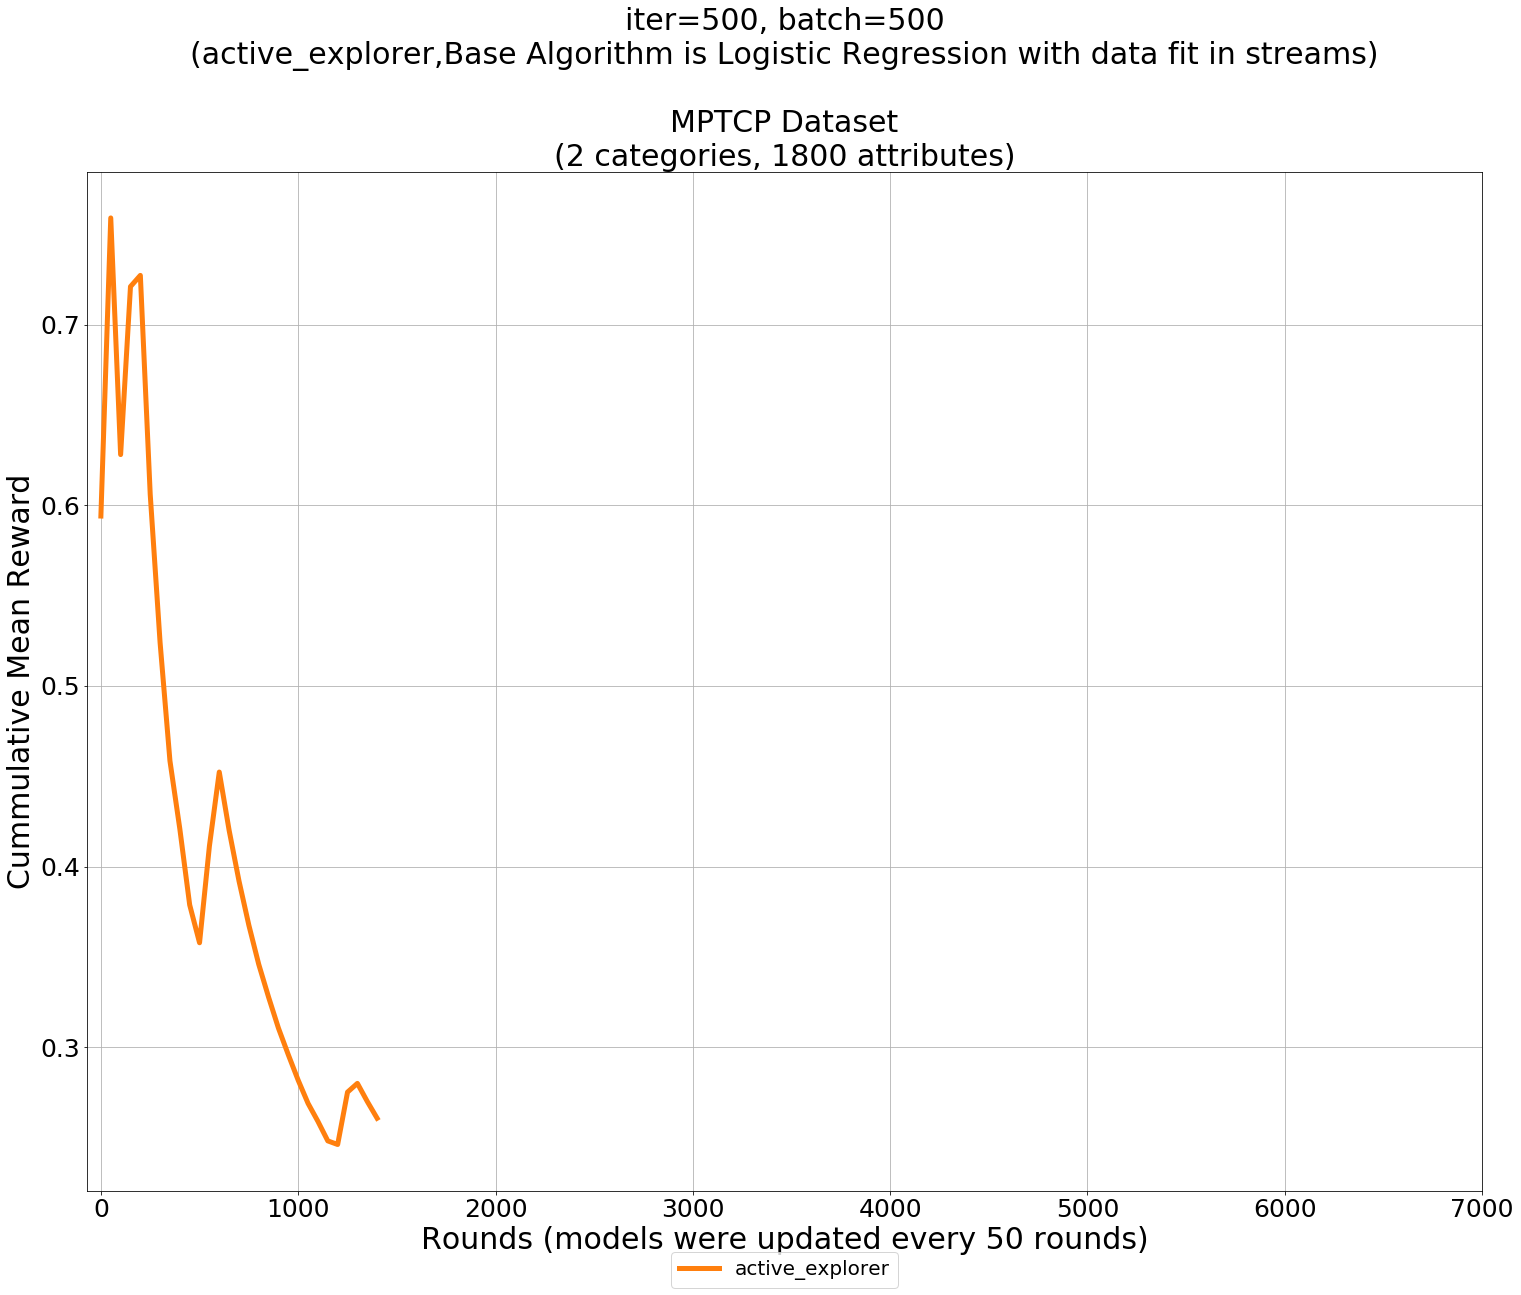

In [18]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=500, batch=500\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [20]:
for i in range(10):
    action = models[0].predict(X[i]).astype("uint8")
    print(action)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


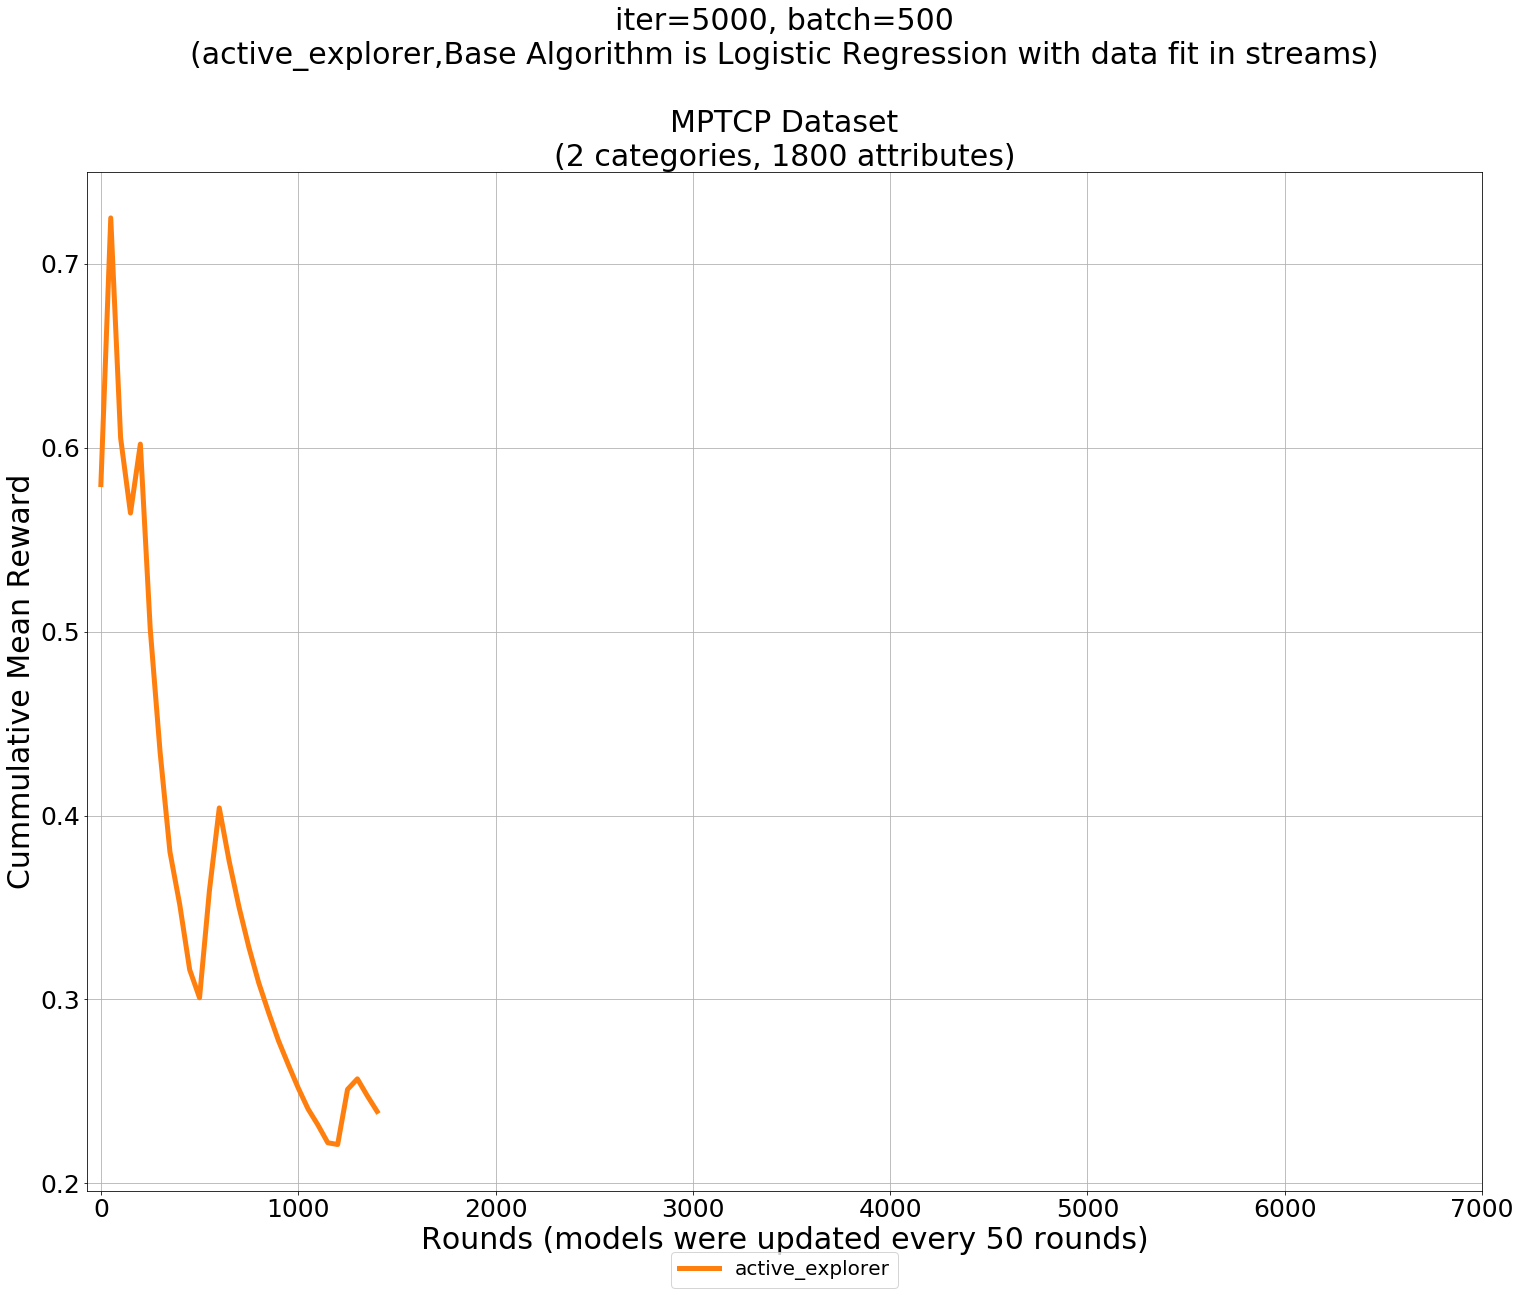

In [23]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('iter=5000, batch=500\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

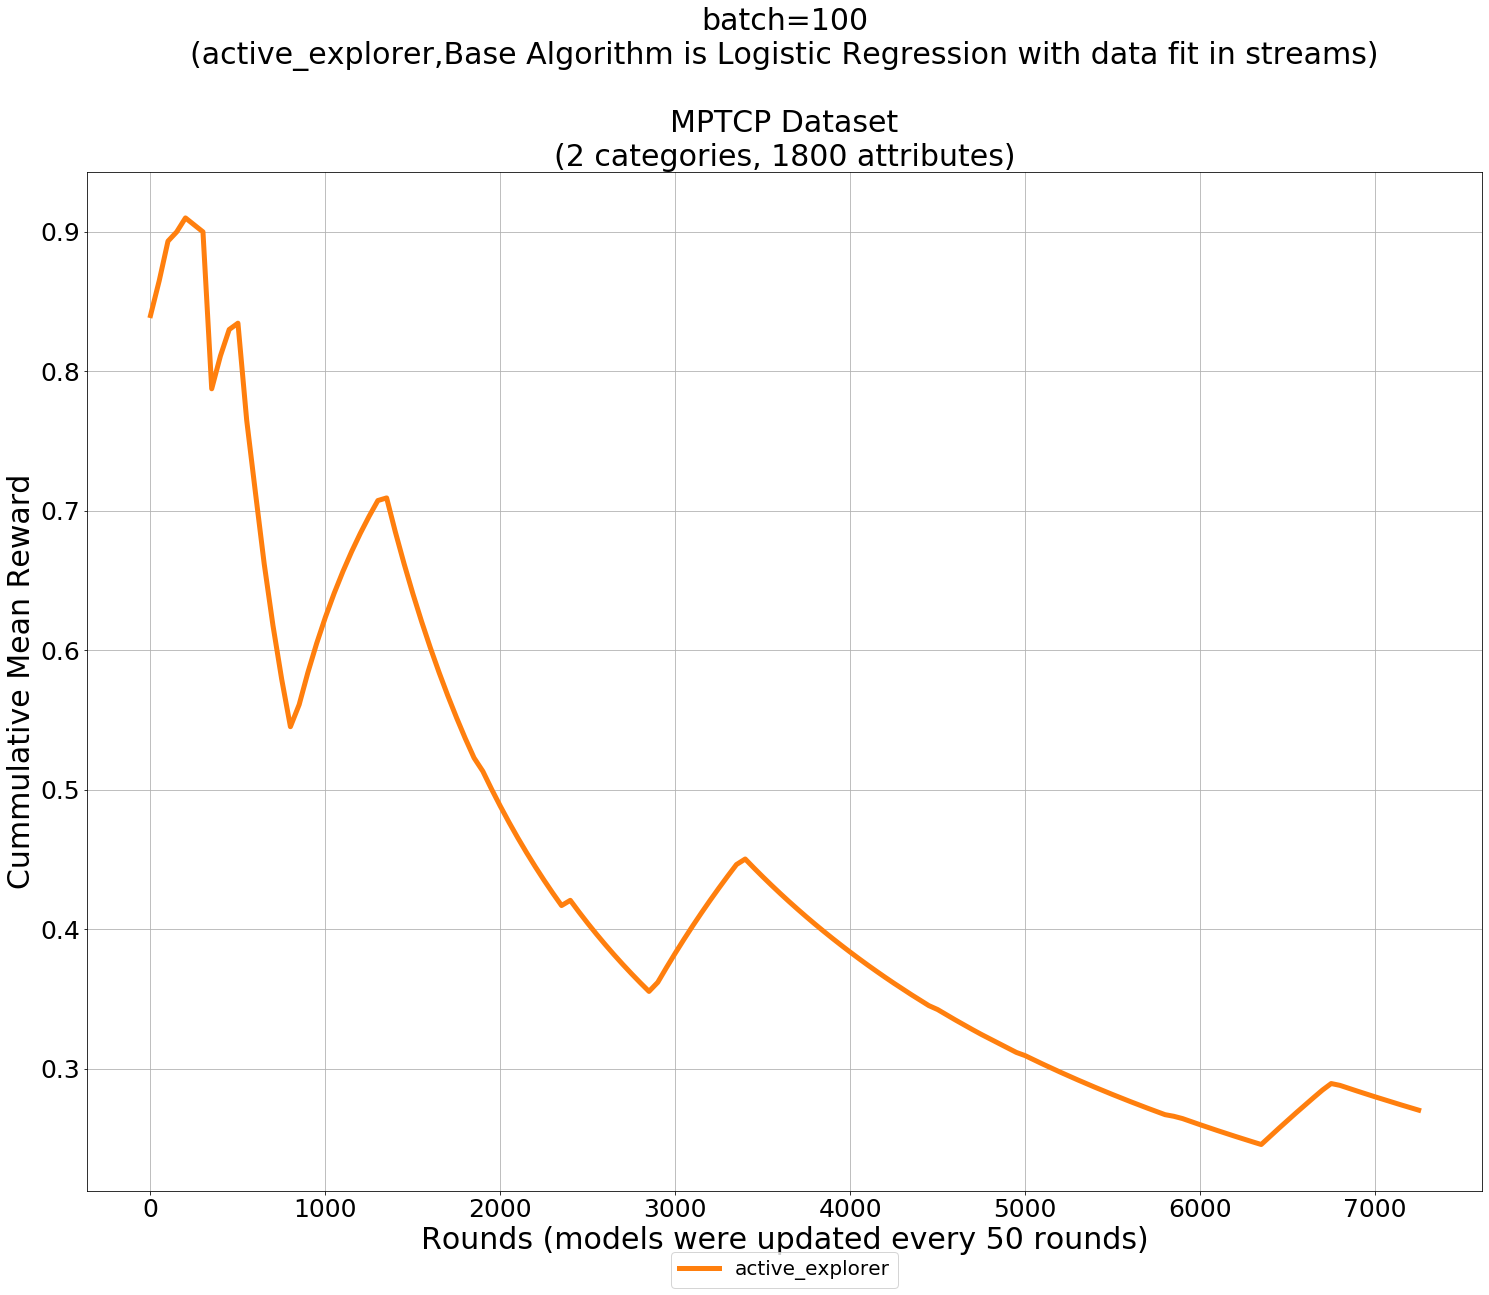

In [26]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('batch=100\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

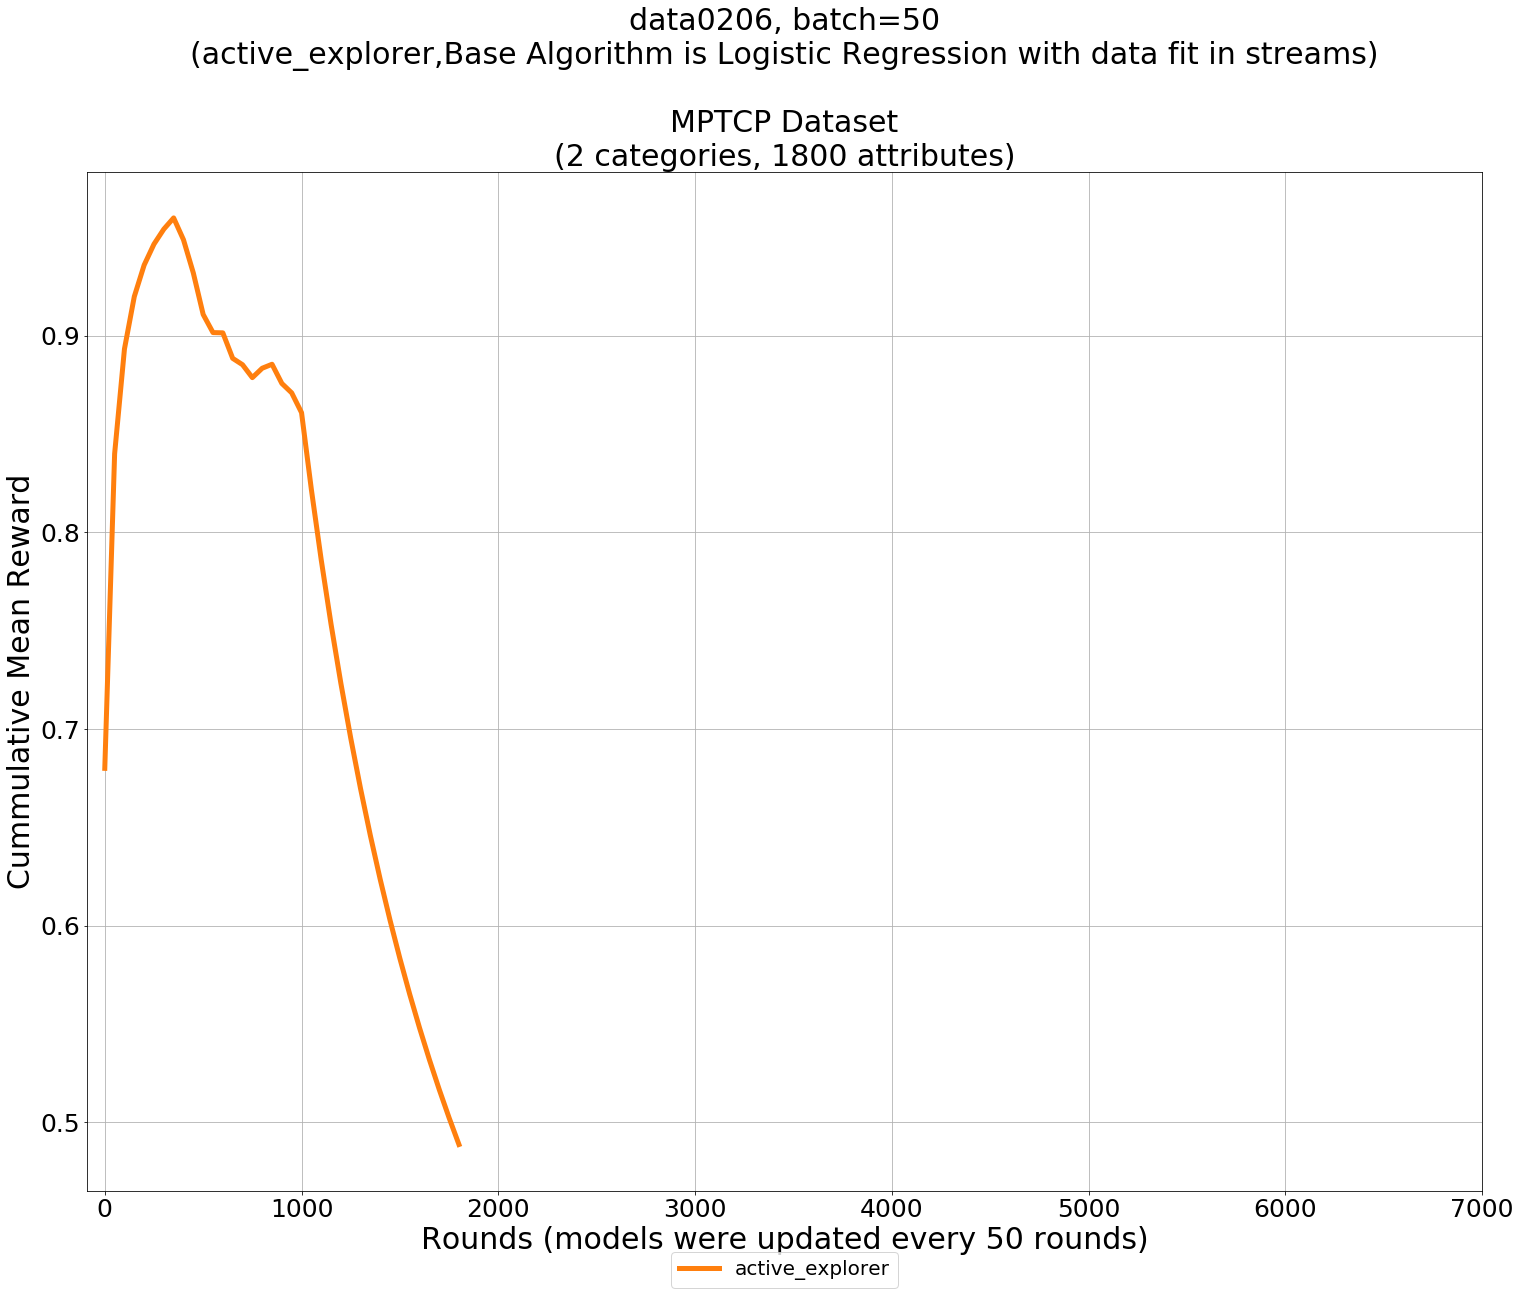

In [30]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('data0206, batch=50\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

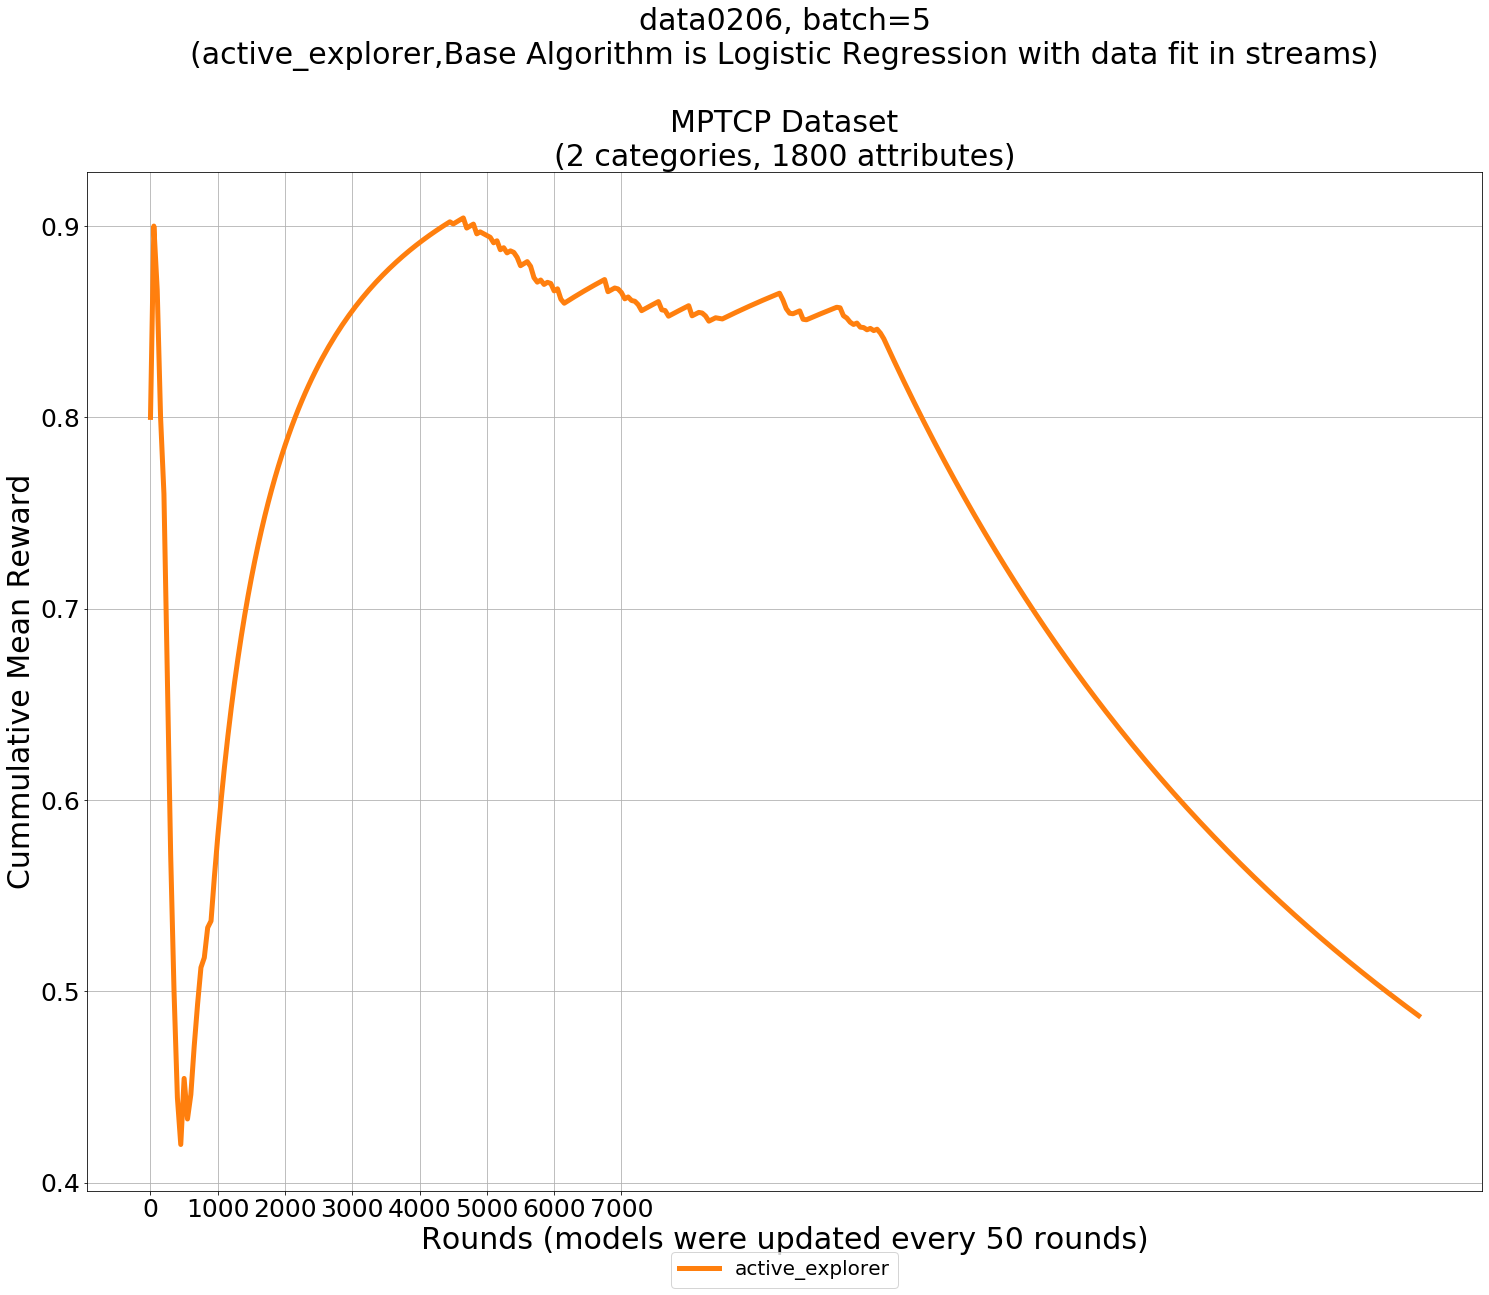

In [32]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('data0206, batch=5\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [58]:
for i in range(10):
    action = models[0].predict(X[-i]).astype("uint8")
    print(action)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [47]:
action = models[0].predict(X[1893]).astype("uint8")
print(action)

[0]


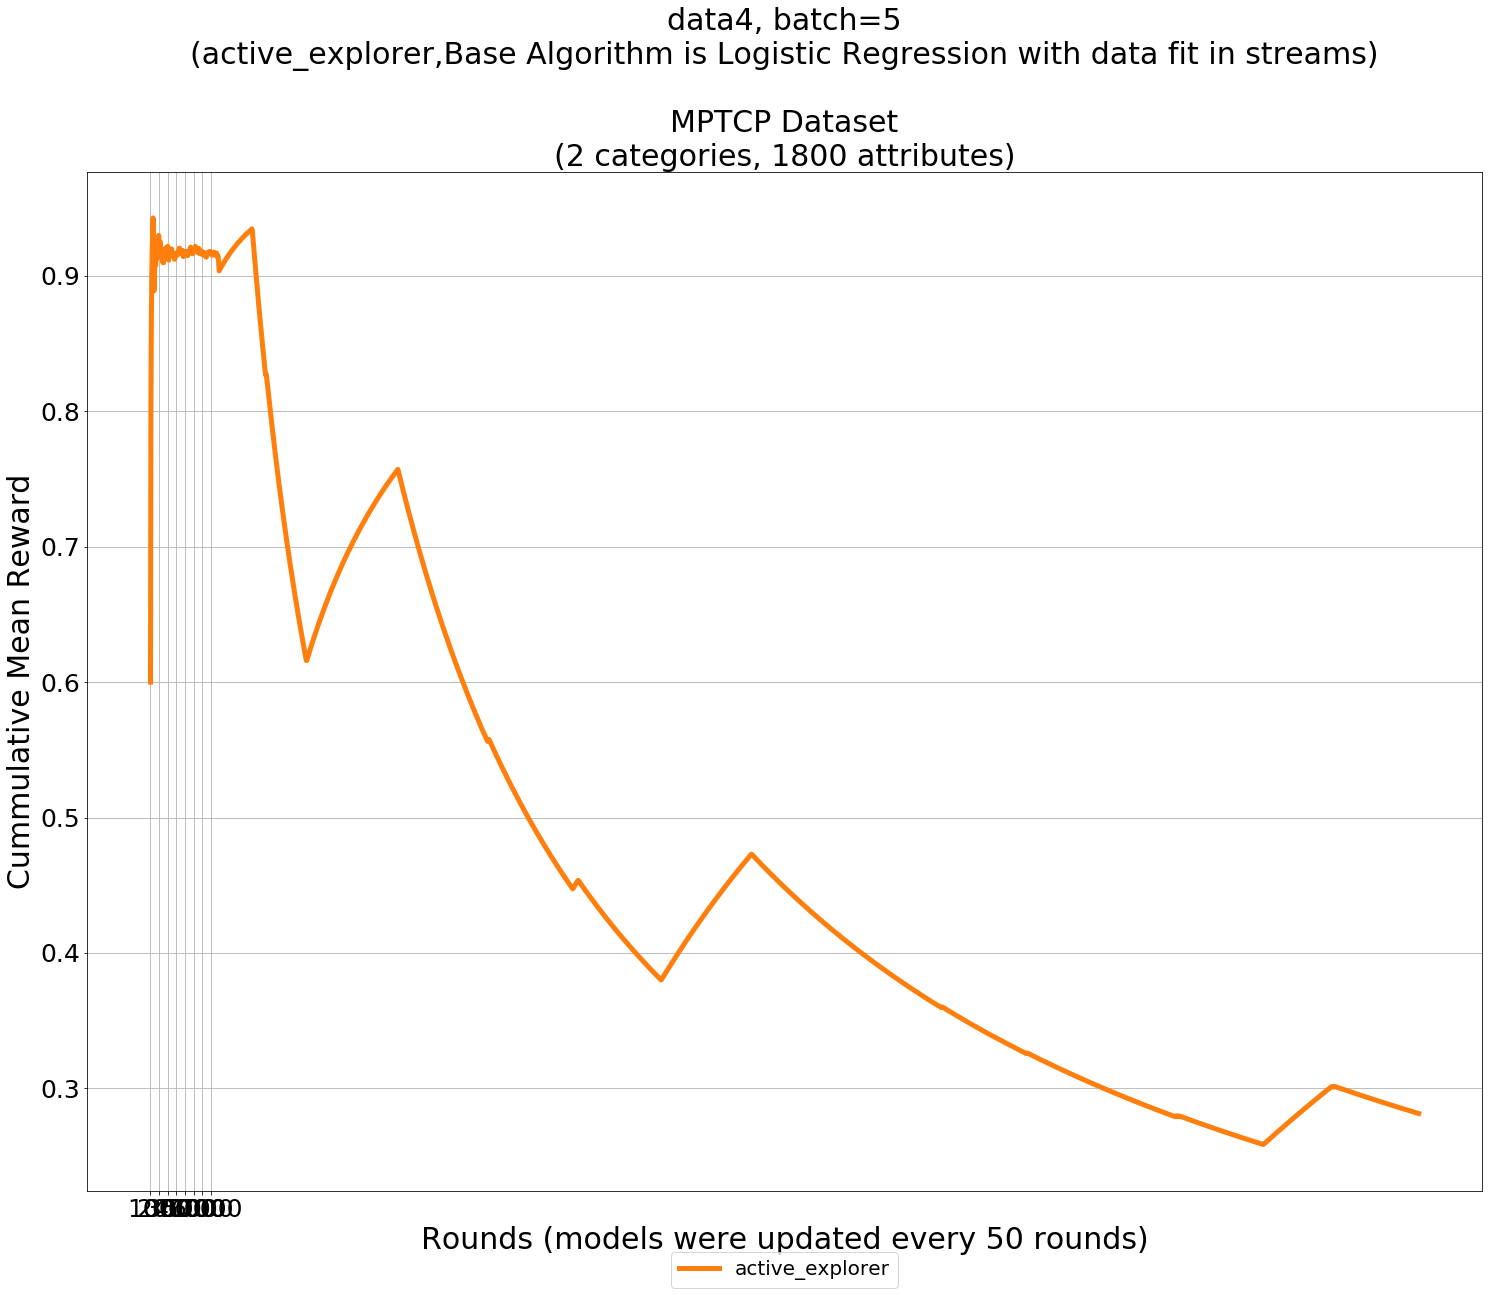

In [51]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('data4, batch=5\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [57]:
for i in range(30):
    action = models[0].predict(X[6624]).astype("uint8")
    print(action)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


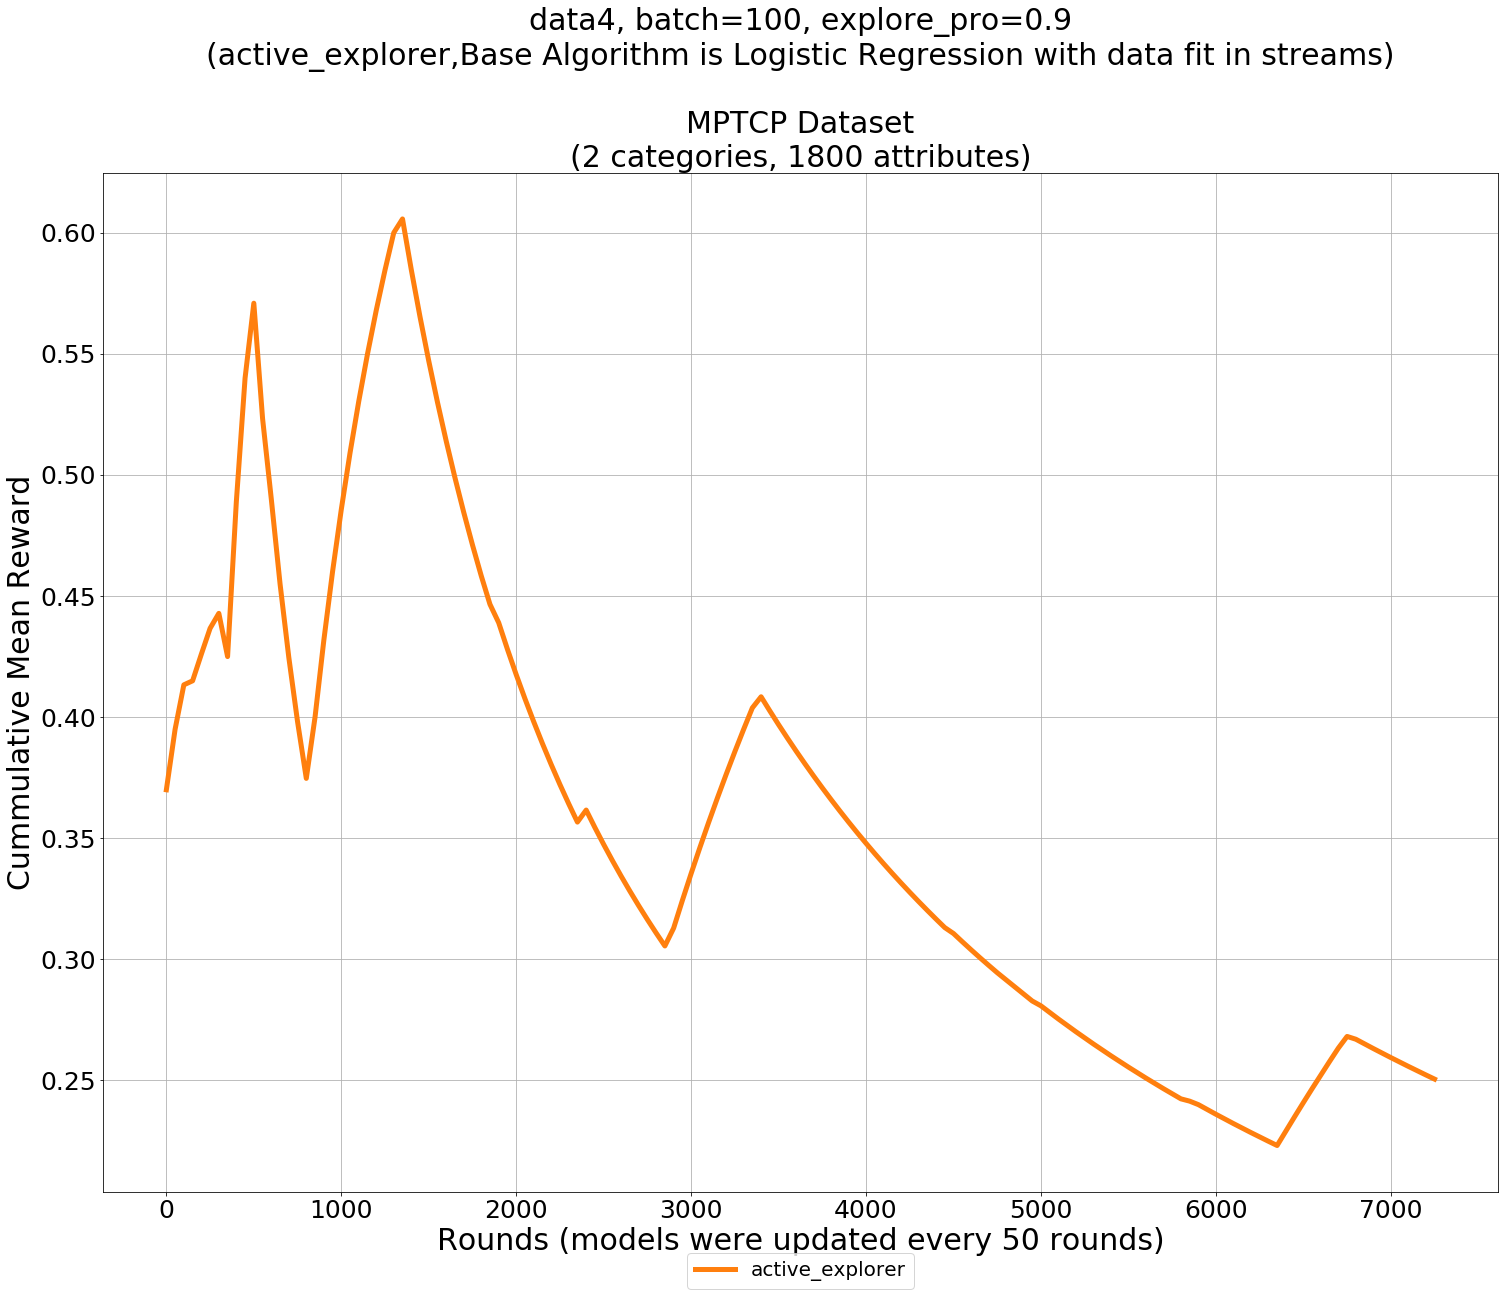

In [61]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('data4, batch=100, explore_pro=0.9\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [112]:
for i in range(10):
    action = models[0].predict(X[866]).astype("uint8")
    print(action, y[866])

[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]
[0] [1 0]


In [101]:
action = models[0].pr 
edict(X[:,:]).astype("uint8")
print(action)

[0 0 0 ... 0 0 0]


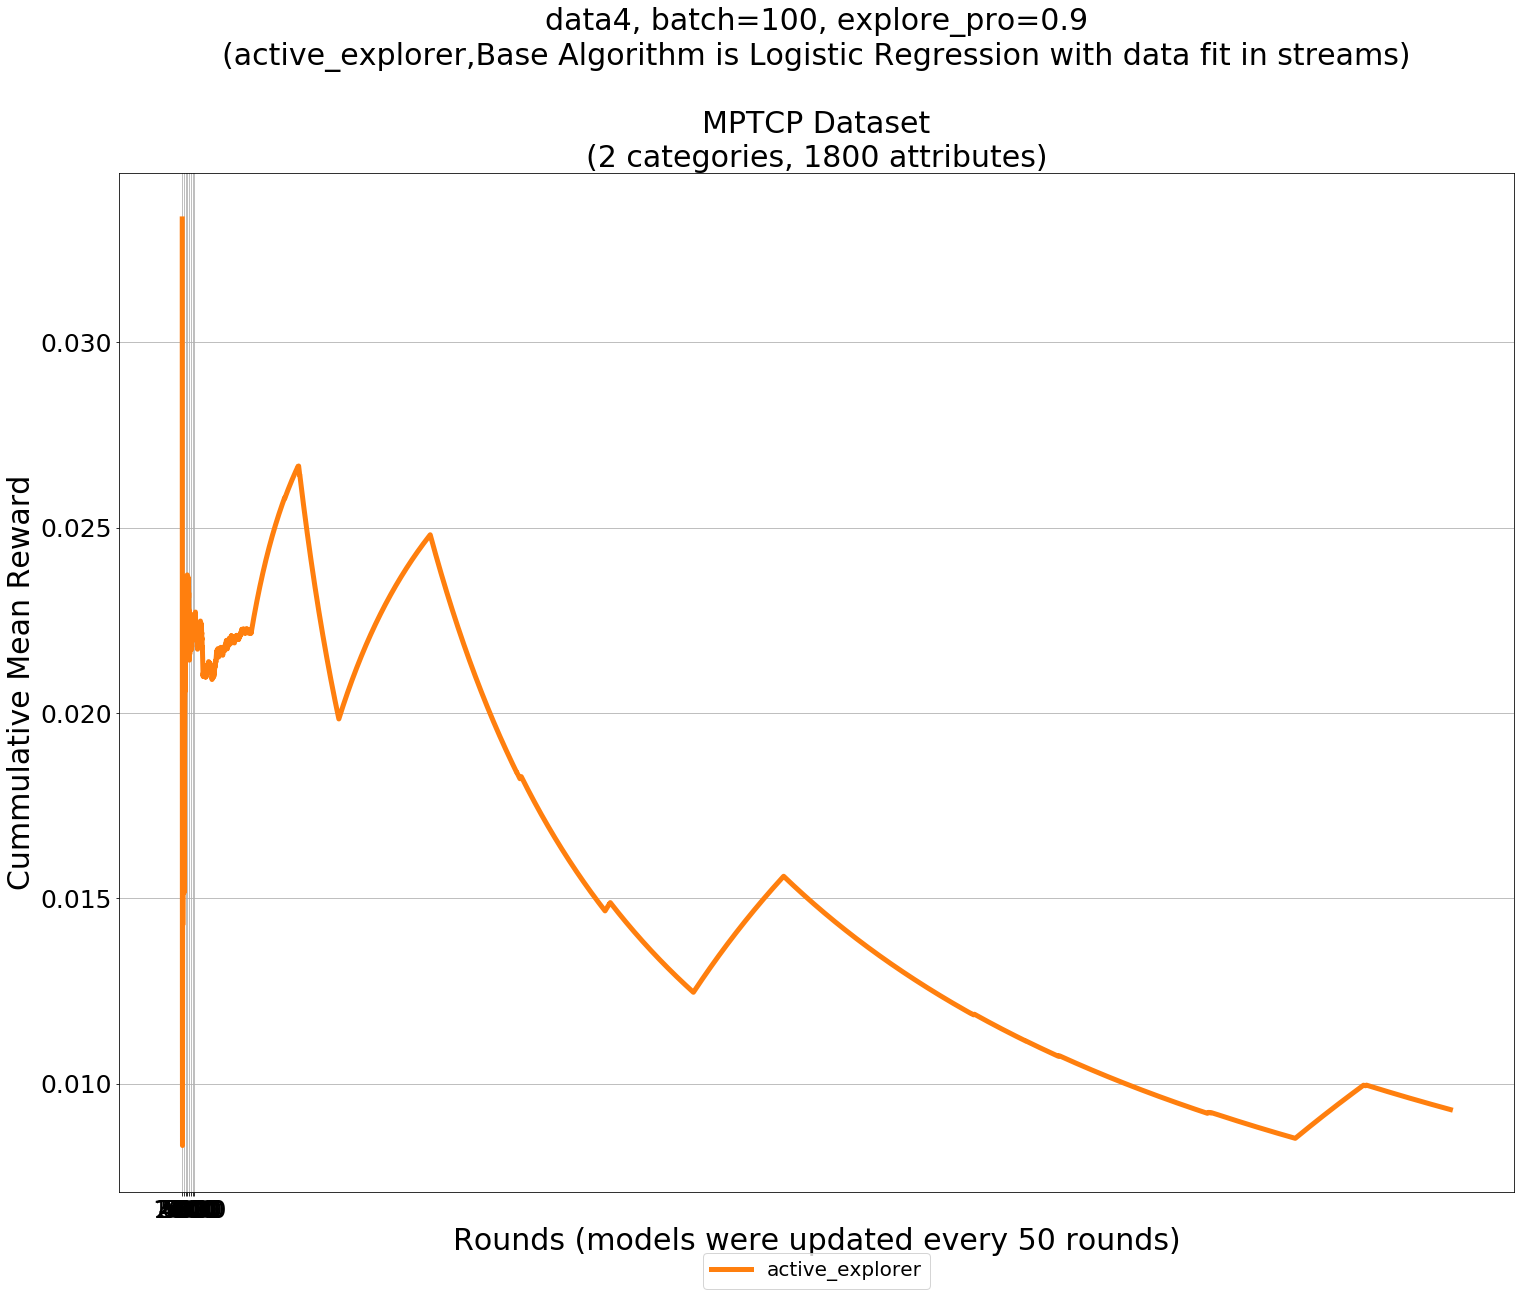

In [144]:
rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)

plt.plot(get_mean_reward(rewards_ac), label="active_explorer", linewidth=lwd,color=colors[2])

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cummulative Mean Reward', size=30)
plt.title('data4, batch=100, explore_pro=0.9\n(active_explorer,Base Algorithm is Logistic Regression with data fit in streams)\n\nMPTCP Dataset\n(2 categories, 1800 attributes)',size=30)
plt.grid()
plt.show()

In [142]:
action = models[0].predict(X[1000]).astype("uint8")
print(action, y[1000])

[0] [1 0]


In [143]:
action = models[0].predict(X[0]).astype("uint8")
print(action, y[0])

[0] [0 1]
